# UTAS-UMAP Visualization

この可視化はUTAS-Polisの後に行われた。残念ながら可視化の際の手順やライブラリの状況を記録していなかったためUTAS-Polisと独立したIPython Notebookとして再現することができなかった。実行可能なNotebookとしてではなく、実験ログとして共有する。

This visualization was conducted after UTAS-Polis. Unfortunately, the procedures and library configurations used during the visualization were not recorded, making it impossible to reproduce it as an independent IPython Notebook separate from UTAS-Polis. It will be shared as an experimental log rather than an executable Notebook.

# UMAP

In [24]:
import umap

# UMAPによる次元削減
reducer = umap.UMAP(
    n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1
)
embedding = reducer.fit_transform(matrix)

# UMAPの結果を含むDataFrameを作成し、matrixのインデックス（User_ID）を含める
umap_df = pd.DataFrame(embedding, columns=["UMAP1", "UMAP2"])
umap_df["User_ID"] = matrix.index  # matrixのインデックスをUser_IDとする

# dataにUser_ID列を追加してから、umap_dfとマージ
data_tmp = data.reset_index().rename(
    columns={"index": "User_ID"}
)  # User_IDとしてインデックスを追加
merged_data = pd.merge(data_tmp, umap_df, on="User_ID", how="inner")  # User_IDで結合

# 政党名の列を追加
merged_data["PARTY_NAME"] = merged_data["PARTY"].map(political_parties)


/Users/nishio/jcpolis/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


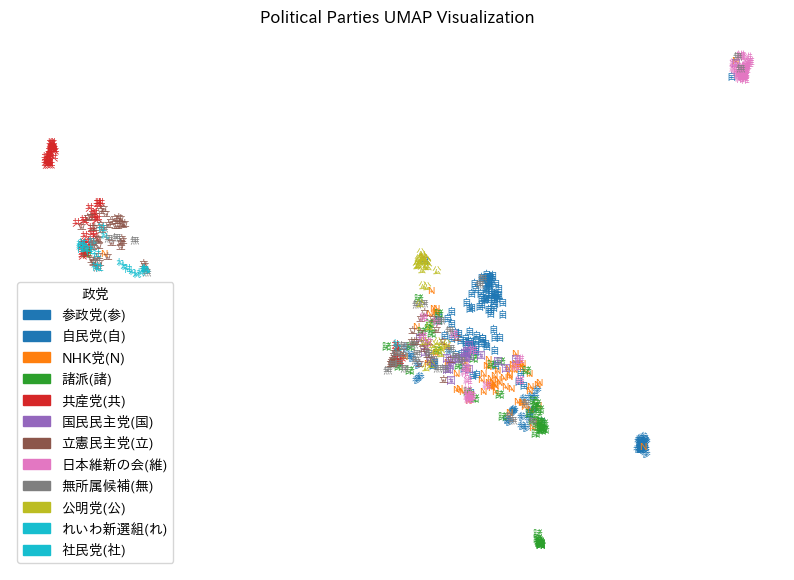

In [ ]:
import matplotlib.patches as mpatches

# カラーマップの準備
unique_parties = merged_data["PARTY"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_parties)))

# 凡例のためのパッチを作成
legend_patches = []
for i, party in enumerate(unique_parties):
    party_data = merged_data[merged_data["PARTY"] == party]
    pname = political_parties[party]
    pletter = parties_letter[political_parties[party]]
    patch = mpatches.Patch(color=colors[i], label=f"{pname}({pletter})")
    legend_patches.append(patch)

def plot_main():
    for i, party in enumerate(unique_parties):
        party_data = merged_data[merged_data["PARTY"] == party]
        pname = political_parties[party]
        pletter = parties_letter[political_parties[party]]
        plt.scatter(
            party_data["UMAP1"],
            party_data["UMAP2"],
            s=1,
            marker=".",
            color=colors[i],
            label=f"{pname}({pletter})",
        )

        for p in party_data.iterrows():
            plt.text(
                p[1]["UMAP1"],
                p[1]["UMAP2"],
                s=pletter,
                color=colors[i],
                fontsize=7,
                ha="center",
                va="center",
            )

# 可視化
plt.figure(figsize=(10, 7))
plot_main()
# 軸を非表示にする
plt.gca().axis('off')
plt.legend(handles=legend_patches, title="政党")


plt.show()

The RectangleSelector was used to monitor selection events and specify clusters through rectangular selection.
`from matplotlib.widgets import RectangleSelector`

RectangleSelectorを使用して選択イベントを監視し、矩形選択でクラスタを指定した。

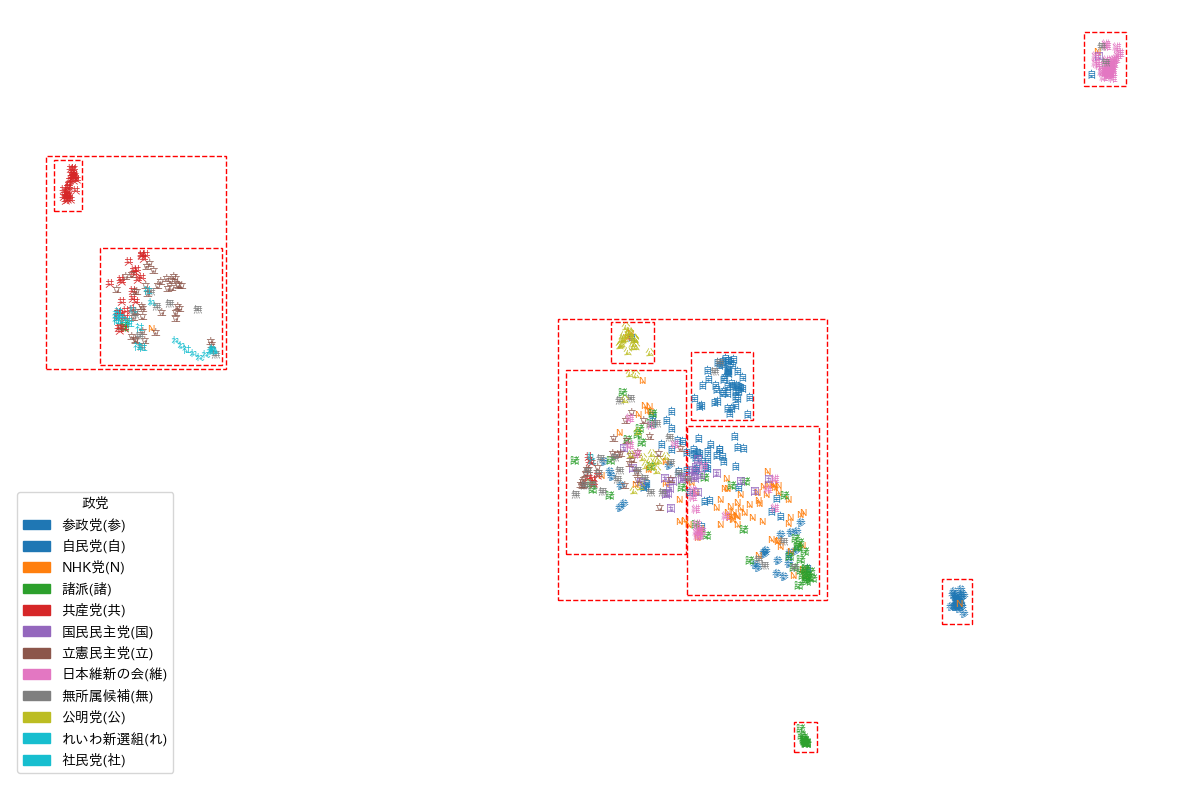

In [ ]:
# 各選択範囲をタプルでリスト化
selected_ranges = [
    (-14.85, -9.30, 6.60, 10.22),
    (-14.58, -13.72, 9.29, 10.15),
    (-13.18, -9.42, 6.67, 8.66),

    (0.90, 9.16, 2.68, 7.45),
    (2.52, 3.86, 6.71, 7.40),
    (4.97, 6.89, 5.73, 6.89),
    (1.14, 4.82, 3.46, 6.58),
    (4.86, 8.93, 2.77, 5.63),

    (17.07, 18.34, 11.40, 12.32),
    (12.71, 13.63, 2.27, 3.04),
    (8.15, 8.85, 0.09, 0.61)
]

def show_selected_ranges(selected_ranges):
    plt.figure(figsize=(15, 10))
    ax = plt.gca()
    plot_main()
    # 軸を非表示にする
    plt.gca().axis('off')
    plt.legend(handles=legend_patches, title="政党")

    # 選択範囲を四角形で表示
    for x_min, x_max, y_min, y_max in selected_ranges:
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=1, edgecolor='red', facecolor='none', linestyle='--'
        )
        ax.add_patch(rect)

    plt.show()

show_selected_ranges(selected_ranges)

各選択範囲ごとの政党の比率 / The party ratio for each selection range

In [60]:
from collections import Counter
# 全体データから指定範囲で絞り込み
for cluster_id, (x_min, x_max, y_min, y_max) in enumerate(selected_ranges):
    # 特定範囲内のデータのみ抽出
    filtered_data = merged_data[(merged_data["UMAP1"] >= x_min) & (merged_data["UMAP1"] <= x_max) & 
                        (merged_data["UMAP2"] >= y_min) & (merged_data["UMAP2"] <= y_max)]

    party_count = {}
    TO_PLOT = False
    if TO_PLOT:
        plt.figure(figsize=(10, 7))

    # 政党ごとに絞り込んでプロット
    for i, party in enumerate(unique_parties):
        # 範囲指定後のデータからさらに政党でフィルタ
        party_data = filtered_data[filtered_data["PARTY"] == party]
        
        pname = political_parties[party]
        pletter = parties_letter[political_parties[party]]
        if TO_PLOT:
            plt.scatter(
                party_data["UMAP1"],
                party_data["UMAP2"],
                s=0,
                marker="+",
                color=colors[i],
                label=f"{pname}({pletter})",
            )

            for p in party_data.iterrows():
                plt.text(
                    p[1]["UMAP1"],
                    p[1]["UMAP2"],
                    s=pletter,
                    color=colors[i],
                    fontsize=10,
                    ha="center",
                    va="center",
                )
        party_count[pname] = len(party_data)
    if TO_PLOT:
        plt.show()
    print(f"C{cluster_id}")
    print(", ".join(f"{k}: {v}"for k, v in Counter(party_count).most_common() if v > 0))
    print("\n" + "-" * 80)

C0
共産党: 58, 立憲民主党: 40, れいわ新選組: 13, 社民党: 12, 無所属候補: 8, 諸派: 2, NHK党: 1

--------------------------------------------------------------------------------
C1
共産党: 31

--------------------------------------------------------------------------------
C2
立憲民主党: 40, 共産党: 27, れいわ新選組: 13, 社民党: 12, 無所属候補: 8, 諸派: 2, NHK党: 1

--------------------------------------------------------------------------------
C3
自民党: 97, NHK党: 72, 諸派: 42, 公明党: 37, 立憲民主党: 29, 無所属候補: 27, 参政党: 22, 国民民主党: 22, 日本維新の会: 19, 共産党: 7, れいわ新選組: 2

--------------------------------------------------------------------------------
C4
公明党: 21, NHK党: 2, 自民党: 1

--------------------------------------------------------------------------------
C5
自民党: 48, 無所属候補: 2

--------------------------------------------------------------------------------
C6
立憲民主党: 29, 無所属候補: 20, 公明党: 16, NHK党: 15, 諸派: 14, 自民党: 13, 国民民主党: 11, 参政党: 7, 共産党: 7, 日本維新の会: 5, れいわ新選組: 2

--------------------------------------------------------------------------------
C7
NHK党:

In [28]:
# 例: 選択範囲0のgroup
clusters = np.zeros(len(cluster_mappings))
x_min, x_max, y_min, y_max = selected_ranges[0]

assert len(cluster_mappings) == len(merged_data)
for row in merged_data.iterrows():
    idx = row[0]
    x, y = row[1]["UMAP1"], row[1]["UMAP2"]
    if x_min <= x <= x_max and y_min <= y <= y_max:
        clusters[idx] = 1


Fisher正確検定を用いたクラスタを特徴付ける意見の抽出(Polis由来) 

Extraction of opinions characterizing clusters using Fisher's exact test (derived from Polis)

In [29]:
def representing_stat(base, clusters):
    matrix=None
    N_v_g_c = np.zeros([3, N_groups, N_comments])  # create N matrix
    P_v_g_c = np.zeros([3, N_groups, N_comments])
    N_g_c = np.zeros([N_groups, N_comments])
    v_values = [-1, 0, 1]

    for g in range(N_groups):
        # get indices of cluster g; caution_ idx != participant id
        idx_g = np.where(clusters == g)[0]
        # print("idx_g", idx_g)
        for c in range(N_comments):
            comment = statements_all_in[c]  # comment id
            # print("comment", comment)

            # data frame: [participants of group g,comment c],
            # gの中にいる人のcomment cの投票値を取得
            df_c = base[comment].iloc[idx_g]
            # print("df_c", df_c)

            for v in range(3):
                v_value = v_values[v]
                # counts all v_value votes in data frame df_c
                # N_v(g,c)は、グループgでコメントcに対して投票値vを付けた人数
                N_v_g_c[v, g, c] = (df_c == v_value).sum()
            # print("N_v_g_c", N_v_g_c)

            # total votes corresponds to votes with +1 or -1
            # N(g,c)は、グループgでコメントcに+1か-1で投票した人数の合計
            N_g_c[g, c] = N_v_g_c[0, g, c] + N_v_g_c[2, g, c]

            # P_v(g,c)は、グループgでコメントcに投票値vを付けた割合（スムージングあり）
            # このスムージングとは、ベイズ推定の文脈でベルヌーイ分布の共役事前分布はベータ分布であることを利用して、MAP推定をしたものに相当する
            # nishio: ここは v in [0, 2] の方が筋が通るのでは(機能に影響はないが) その場合はこのグループが賛成/反対をする確率の推定になる
            for v in range(3):
                P_v_g_c[v, g, c] = (1 + N_v_g_c[v, g, c]) / (2 + N_g_c[g, c])

    # Step2: calculate R_v(g,c)
    # 代表性尺度 (see Paper)
    # R_v(g,c)は、グループg以外でのP_v(g,c)の合計に対するP_v(g,c)の比率
    # R_v(g,c) は、グループ g 以外の全グループにおける投票値 v の割合の合計に対する、グループ g での投票値 v の割合の比率を表します。
    R_v_g_c = np.zeros([3, N_groups, N_comments])
    for g in range(N_groups):
        for c in range(N_comments):
            for v in range(3):
                # np.delete neglects all entries with group g
                R_v_g_c[v, g, c] = (
                    P_v_g_c[v, g, c] / np.delete(P_v_g_c[v, :, c], g, 0).sum()
                )

    # Fisherの正確確率検定
    from scipy.stats import hypergeom

    v_values = [-1, 0, 1]
    p_values = np.zeros([N_groups, N_comments, 3])
    for g in range(N_groups):
        idx_g = np.where(clusters == g)[
            0
        ]  # get indices of cluster g; caution_ idx != participant id
        # idx_g_not = np.where(clusters_star != g)[0]  # get indices of rest
        for c in range(N_comments):
            comment = statements_all_in[c]  # comment id

            for v in range(3):
                v_value = v_values[v]

                # totol number of v votes in comment c
                N_v = (base[comment] == v_value).sum()

                # total number of votes =  number of participants
                N_total = (base[comment]).count()
                N_rest = N_total - N_v

                # get data frame of group g for comment c
                df_c = base[comment].iloc[idx_g]
                # number of v votes in group g
                N_v_in_g = (df_c == v_value).sum()
                # number of votes in group g
                N_g = (df_c).count()

                [M, n, N] = [
                    N_rest + N_v,
                    N_v,
                    N_g,
                ]  # hypergeometric distribution parameters https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html
                x = range(N_v_in_g - 1, N_g + 1)
                prb = hypergeom.pmf(
                    x, M, n, N
                ).sum()  # calculates P(X>=N_v_in_g), i.e. p-value.
                p_values[g, c, v] = prb * R_v_g_c[v, g, c]

    # Compute total vote counts for each comment
    total_vote_counts = np.zeros([3, N_comments])
    for v in range(3):
        v_value = v_values[v]
        for c in range(N_comments):
            comment = statements_all_in[c]
            total_vote_counts[v, c] = (base[comment] == v_value).sum()

    return p_values, total_vote_counts, N_v_g_c


In [ ]:
AGREE_GREEN = "#3BE385"
DISAGREE_RED = "#E24348"
NEUTRAL_GRAY = "#4B535C"
def show_vote_bar(a2, a1, a0, sa, b2, b1, b0, sb, ax=None):
    TO_SHOW = False
    if not ax:
        plt.figure(figsize=(7, 1))
        ax = plt.gca()
        TO_SHOW = True
    ax.invert_yaxis()
    ax.set_xlim(0, 1)
    # 枠線を非表示
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.barh(["内", "外"], [a2 / sa, b2 / sb], color=AGREE_GREEN)
    ax.barh(["内", "外"], [a1 / sa, b1 / sb], left=[a2 / sa, b2 / sb], color=NEUTRAL_GRAY)
    ax.barh(["内", "外"], [a0 / sa, b0 / sb], left=[(a2 + a1) / sa, (b2 + b1) / sb], color=DISAGREE_RED)
    if TO_SHOW:
        plt.show()

def display_multiple_votes(votes, questions):
    fig, axes = plt.subplots(len(votes), 1, figsize=(7, len(votes) * 1.5))
    fig.subplots_adjust(hspace=1)

    for i, (vote, question) in enumerate(zip(votes, questions)):
        ax = axes[i] if len(votes) > 1 else axes  # 1つの場合の例外処理
        ax.set_title(question)
        show_vote_bar(*vote, ax)

    plt.show()


Show outputs / 結果の出力

オリジナルのPolisではクラスタがMECEな想定だったが、その制約を外している

In the original Polis, clusters were assumed to be MECE (Mutually Exclusive and Collectively Exhaustive), but this restriction has been removed.

In [ ]:
# 結果の出力
# ここがオリジナルではMECEな想定だったが、その制約を外している
# デフォルトでは、group id == 1のものを出す
def show_representing_comments(
        p_values, total_vote_counts, N_v_g_c, g=1, 
        TOP_N_MAX=5, show_plot=True):
    buf = []
    idx_ = np.argsort(p_values[g, :, 0])  # take only the significant comments
    for i in range(TOP_N_MAX):
        print(" ")
        # print(df_comments["comment-body"][idx_[i]])
        c = idx_[i]
        q = statements_all_in[c]
        q = q.replace(".0", "")
        comment = q + readable.get(q, "")
        print("comment", c, ":", comment)
        a2 = N_v_g_c[2, g, c]
        a1 = N_v_g_c[1, g, c]
        a0 = N_v_g_c[0, g, c]
        s = a2 + a1 + a0
        sa = s
        print(f"## In-group: agree: {a2/s*100:.1f}% neutral: {a1/s*100:.1f}% disagree: {a0/s*100:.1f}%", f"{a2}, {a1}, {a0}, (N={s})")

        b2 = total_vote_counts[2, c] - N_v_g_c[2, g, c]
        b1 = total_vote_counts[1, c] - N_v_g_c[1, g, c]
        b0 = total_vote_counts[0, c] - N_v_g_c[0, g, c]
        s = b2 + b1 + b0
        sb = s
        print(f"## Out-group: agree: {b2/s*100:.1f}% neutral: {b1/s*100:.1f}% disagree: {b0/s*100:.1f}%", f"{b2}, {b1}, {b0}, (N={s})")
        print("pvalue: ", p_values[g, c, 0])

        if show_plot:
            show_vote_bar(a2, a1, a0, sa, b2, b1, b0, sb)

        buf.append(
           [comment, a2, a1, a0, sa, b2, b1, b0, sb]
        )
        if p_values[g, c, 0] >= 0.05:
            break

    # print("total votes in group: ", N_g_c[g, c])
    for [comment, a2, a1, a0, sa, b2, b1, b0, sb] in buf:
        addition = ""
        if a2 / sa > b2 / sb:
            addition += "他のクラスタより賛成が多い"
        if a0 / sa > b0 / sb:
            addition += "他のクラスタより反対が多い"

        print(f"## {comment}\n" + 
              f"このグループ:  賛成: {a2/sa*100:.0f}% 中立: {a1/sa*100:.0f}% 反対: {a0/sa*100:.0f}%\n" +
              f"他のグループ:  賛成: {b2/sb*100:.0f}% 中立: {b1/sb*100:.0f}% 反対: {b0/sb*100:.0f}%\n{addition}\n")
    display_multiple_votes([x[1:] for x in buf], [x[0] for x in buf])


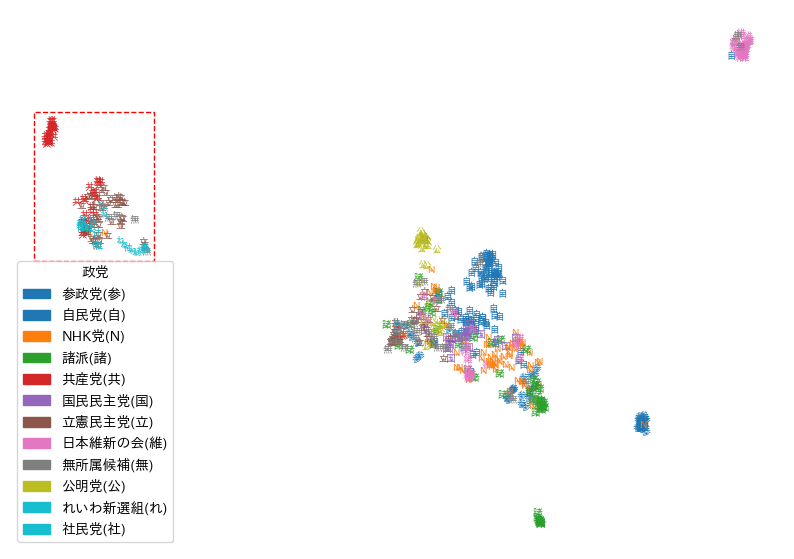

 
comment 11 : Q4_7沖縄県の普天間基地の辺野古移設はやむをえない
## In-group: agree: 0.7% neutral: 2.2% disagree: 97.0% 1.0, 3.0, 130.0, (N=134.0)
## Out-group: agree: 55.0% neutral: 32.6% disagree: 12.4% 204.0, 121.0, 46.0, (N=371.0)
pvalue:  6.586533724286037e-82


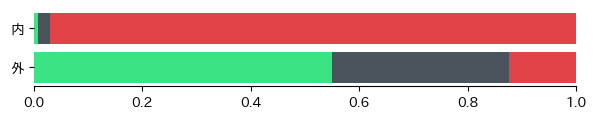

 
comment 10 : Q4_6首相には靖国神社に参拝してほしい
## In-group: agree: 0.0% neutral: 6.7% disagree: 93.3% 0.0, 9.0, 125.0, (N=134.0)
## Out-group: agree: 56.2% neutral: 32.4% disagree: 11.4% 208.0, 120.0, 42.0, (N=370.0)
pvalue:  3.674558295899059e-76


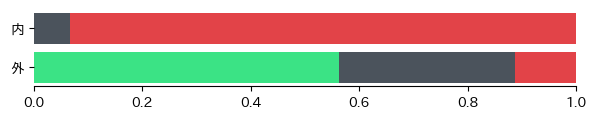

 
comment 6 : Q4_2他国からの攻撃が予想される場合には敵基地攻撃もためらうべきではない
## In-group: agree: 1.5% neutral: 0.0% disagree: 98.5% 2.0, 0.0, 132.0, (N=134.0)
## Out-group: agree: 59.5% neutral: 21.7% disagree: 18.8% 269.0, 98.0, 85.0, (N=452.0)
pvalue:  2.9941009470161284e-67


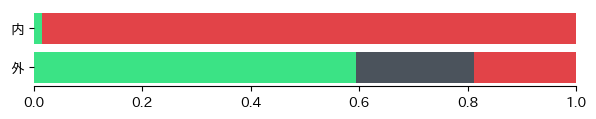

 
comment 24 : Q4_20福島第一原発の処理水の海洋放出はやむをえない
## In-group: agree: 0.7% neutral: 7.5% disagree: 91.8% 1.0, 10.0, 123.0, (N=134.0)
## Out-group: agree: 62.5% neutral: 20.8% disagree: 16.7% 232.0, 77.0, 62.0, (N=371.0)
pvalue:  2.8843707876881174e-63


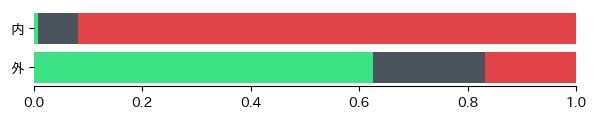

 
comment 5 : Q4_1日本の防衛力はもっと強化すべきだ
## In-group: agree: 10.5% neutral: 16.5% disagree: 72.9% 14.0, 22.0, 97.0, (N=133.0)
## Out-group: agree: 84.0% neutral: 9.9% disagree: 6.2% 382.0, 45.0, 28.0, (N=455.0)
pvalue:  2.3923227617035712e-51


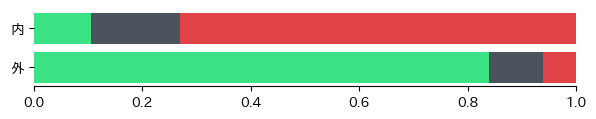

## Q4_7沖縄県の普天間基地の辺野古移設はやむをえない
このグループ:  賛成: 1% 中立: 2% 反対: 97%
他のグループ:  賛成: 55% 中立: 33% 反対: 12%
他のクラスタより反対が多い

## Q4_6首相には靖国神社に参拝してほしい
このグループ:  賛成: 0% 中立: 7% 反対: 93%
他のグループ:  賛成: 56% 中立: 32% 反対: 11%
他のクラスタより反対が多い

## Q4_2他国からの攻撃が予想される場合には敵基地攻撃もためらうべきではない
このグループ:  賛成: 1% 中立: 0% 反対: 99%
他のグループ:  賛成: 60% 中立: 22% 反対: 19%
他のクラスタより反対が多い

## Q4_20福島第一原発の処理水の海洋放出はやむをえない
このグループ:  賛成: 1% 中立: 7% 反対: 92%
他のグループ:  賛成: 63% 中立: 21% 反対: 17%
他のクラスタより反対が多い

## Q4_1日本の防衛力はもっと強化すべきだ
このグループ:  賛成: 11% 中立: 17% 反対: 73%
他のグループ:  賛成: 84% 中立: 10% 反対: 6%
他のクラスタより反対が多い



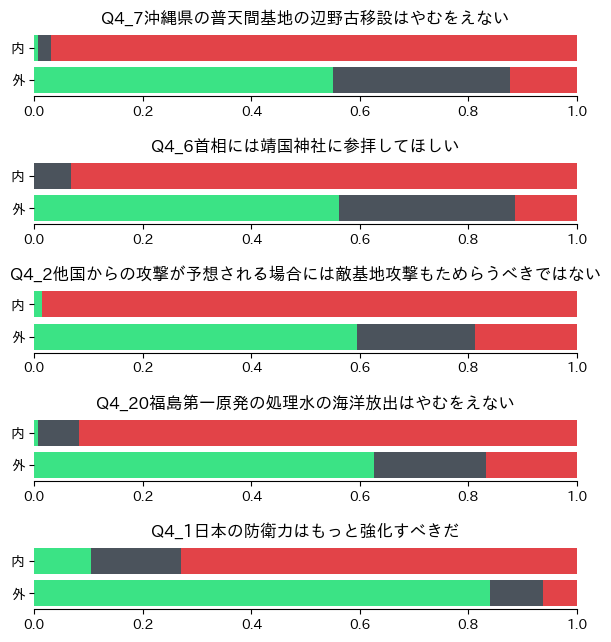

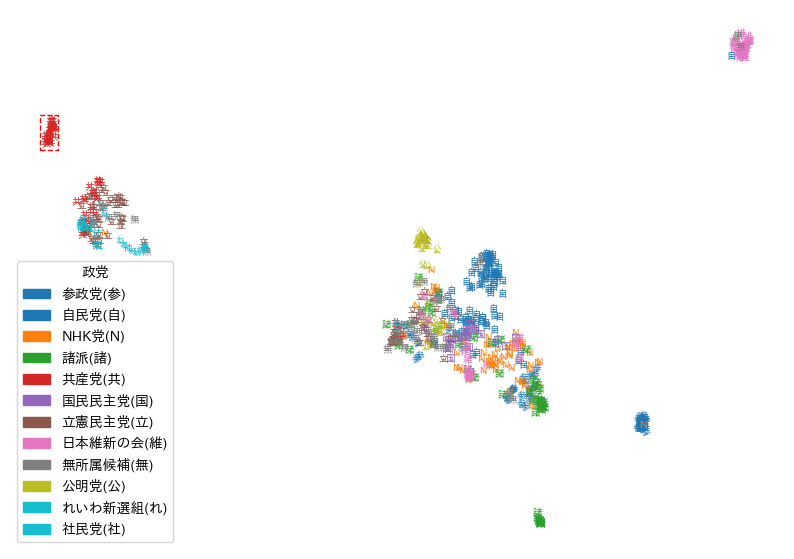

 
comment 25 : Q4_21新型コロナウイルスの感染法上の位置づけを季節性インフルエンザと同じ５類に引き下げるべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 31.0, (N=31.0)
## Out-group: agree: 62.7% neutral: 21.5% disagree: 15.8% 297.0, 102.0, 75.0, (N=474.0)
pvalue:  1.116633316645739e-22


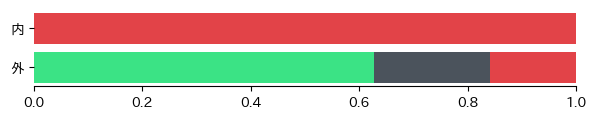

 
comment 5 : Q4_1日本の防衛力はもっと強化すべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 31.0, (N=31.0)
## Out-group: agree: 71.1% neutral: 12.0% disagree: 16.9% 396.0, 67.0, 94.0, (N=557.0)
pvalue:  3.3903209893780837e-20


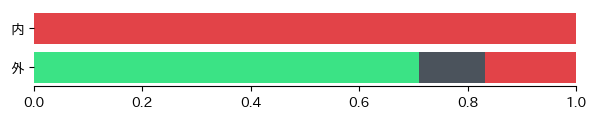

 
comment 4 : Q3_5日本銀行は国債の買入れなど量的金融緩和政策を続ける
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 31.0, (N=31.0)
## Out-group: agree: 48.7% neutral: 25.4% disagree: 25.8% 230.0, 120.0, 122.0, (N=472.0)
pvalue:  1.60915129941394e-17


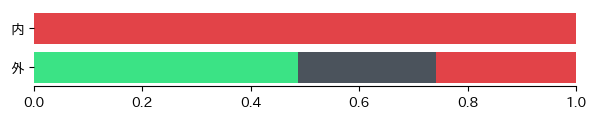

 
comment 38 : Q5_7国債は安定的に消化されており、財政赤字を心配する必要はない / 財政赤字は危機的水準であるので、国債発行を抑制すべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 31.0, (N=31.0)
## Out-group: agree: 39.7% neutral: 38.1% disagree: 22.2% 220.0, 211.0, 123.0, (N=554.0)
pvalue:  1.9277261722208935e-17


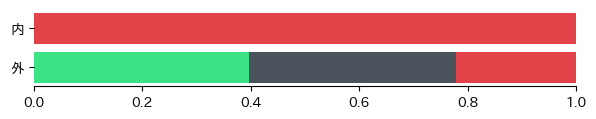

 
comment 19 : Q4_15全農の株式会社化や信用事業の分離など、農協の組織改革をさらに進めるべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 31.0, (N=31.0)
## Out-group: agree: 36.1% neutral: 37.4% disagree: 26.5% 170.0, 176.0, 125.0, (N=471.0)
pvalue:  2.4963395557959286e-17


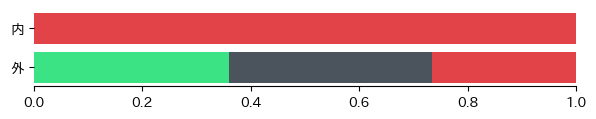

## Q4_21新型コロナウイルスの感染法上の位置づけを季節性インフルエンザと同じ５類に引き下げるべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 63% 中立: 22% 反対: 16%
他のクラスタより反対が多い

## Q4_1日本の防衛力はもっと強化すべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 71% 中立: 12% 反対: 17%
他のクラスタより反対が多い

## Q3_5日本銀行は国債の買入れなど量的金融緩和政策を続ける
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 49% 中立: 25% 反対: 26%
他のクラスタより反対が多い

## Q5_7国債は安定的に消化されており、財政赤字を心配する必要はない / 財政赤字は危機的水準であるので、国債発行を抑制すべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 40% 中立: 38% 反対: 22%
他のクラスタより反対が多い

## Q4_15全農の株式会社化や信用事業の分離など、農協の組織改革をさらに進めるべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 36% 中立: 37% 反対: 27%
他のクラスタより反対が多い



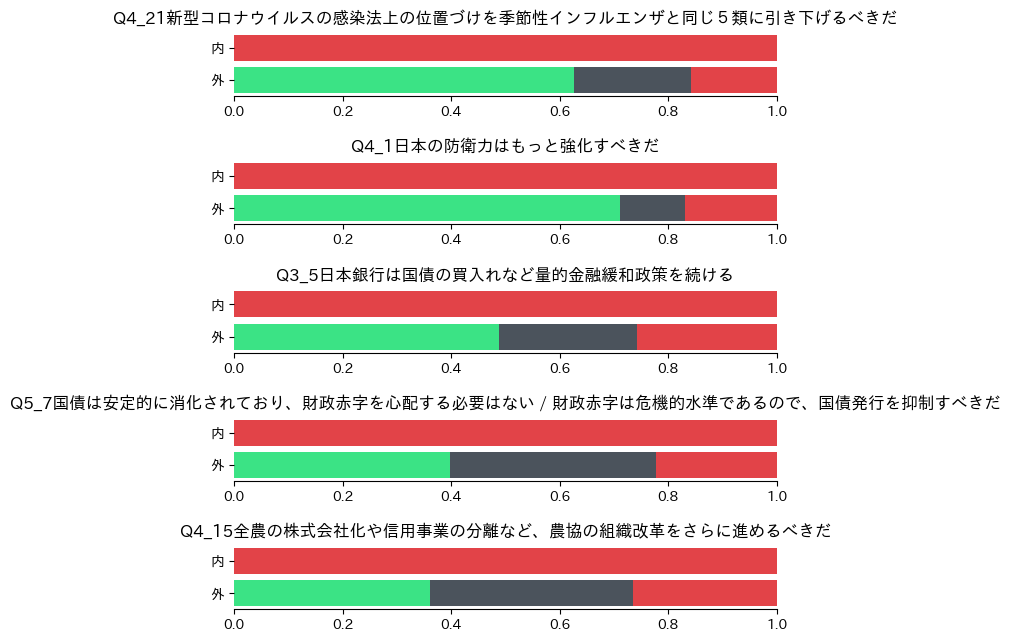

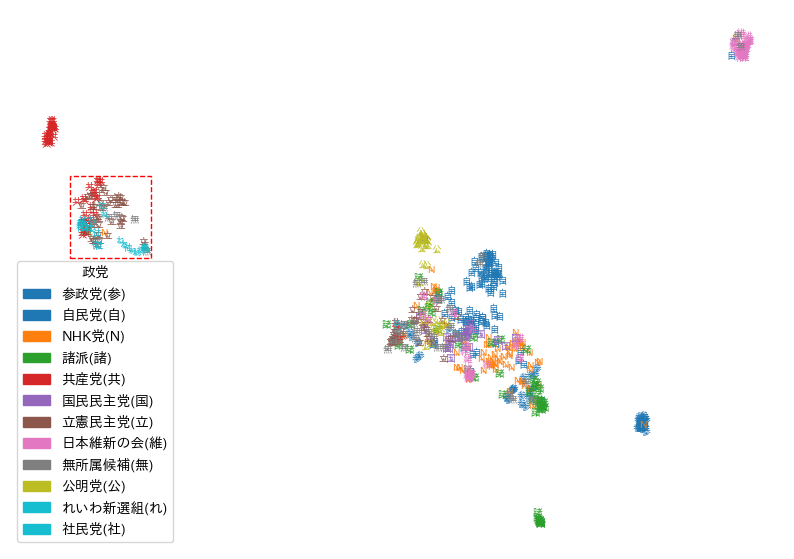

 
comment 11 : Q4_7沖縄県の普天間基地の辺野古移設はやむをえない
## In-group: agree: 1.0% neutral: 2.9% disagree: 96.1% 1.0, 3.0, 99.0, (N=103.0)
## Out-group: agree: 50.7% neutral: 30.1% disagree: 19.2% 204.0, 121.0, 77.0, (N=402.0)
pvalue:  2.3622121164395442e-55


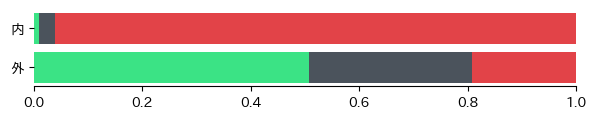

 
comment 10 : Q4_6首相には靖国神社に参拝してほしい
## In-group: agree: 0.0% neutral: 8.7% disagree: 91.3% 0.0, 9.0, 94.0, (N=103.0)
## Out-group: agree: 51.9% neutral: 29.9% disagree: 18.2% 208.0, 120.0, 73.0, (N=401.0)
pvalue:  2.5269758435959763e-49


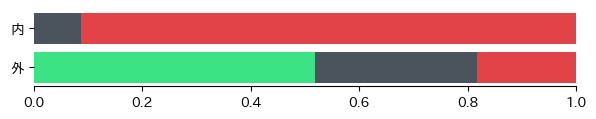

 
comment 6 : Q4_2他国からの攻撃が予想される場合には敵基地攻撃もためらうべきではない
## In-group: agree: 1.9% neutral: 0.0% disagree: 98.1% 2.0, 0.0, 101.0, (N=103.0)
## Out-group: agree: 55.7% neutral: 20.3% disagree: 24.0% 269.0, 98.0, 116.0, (N=483.0)
pvalue:  5.810181337036905e-47


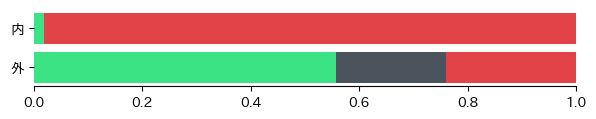

 
comment 24 : Q4_20福島第一原発の処理水の海洋放出はやむをえない
## In-group: agree: 1.0% neutral: 9.7% disagree: 89.3% 1.0, 10.0, 92.0, (N=103.0)
## Out-group: agree: 57.7% neutral: 19.2% disagree: 23.1% 232.0, 77.0, 93.0, (N=402.0)
pvalue:  1.263224071901682e-40


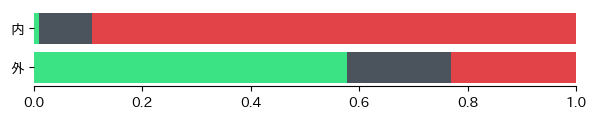

 
comment 1 : Q3_2年金や医療費の給付を現行の水準よりも抑制する
## In-group: agree: 1.0% neutral: 3.9% disagree: 95.1% 1.0, 4.0, 98.0, (N=103.0)
## Out-group: agree: 17.0% neutral: 41.4% disagree: 41.6% 68.0, 166.0, 167.0, (N=401.0)
pvalue:  1.6078603421226187e-31


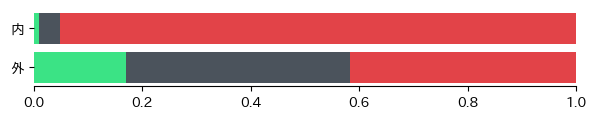

## Q4_7沖縄県の普天間基地の辺野古移設はやむをえない
このグループ:  賛成: 1% 中立: 3% 反対: 96%
他のグループ:  賛成: 51% 中立: 30% 反対: 19%
他のクラスタより反対が多い

## Q4_6首相には靖国神社に参拝してほしい
このグループ:  賛成: 0% 中立: 9% 反対: 91%
他のグループ:  賛成: 52% 中立: 30% 反対: 18%
他のクラスタより反対が多い

## Q4_2他国からの攻撃が予想される場合には敵基地攻撃もためらうべきではない
このグループ:  賛成: 2% 中立: 0% 反対: 98%
他のグループ:  賛成: 56% 中立: 20% 反対: 24%
他のクラスタより反対が多い

## Q4_20福島第一原発の処理水の海洋放出はやむをえない
このグループ:  賛成: 1% 中立: 10% 反対: 89%
他のグループ:  賛成: 58% 中立: 19% 反対: 23%
他のクラスタより反対が多い

## Q3_2年金や医療費の給付を現行の水準よりも抑制する
このグループ:  賛成: 1% 中立: 4% 反対: 95%
他のグループ:  賛成: 17% 中立: 41% 反対: 42%
他のクラスタより反対が多い



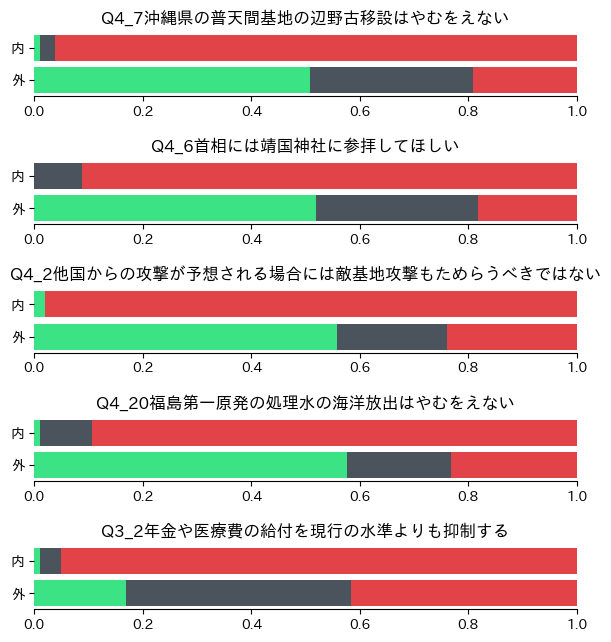

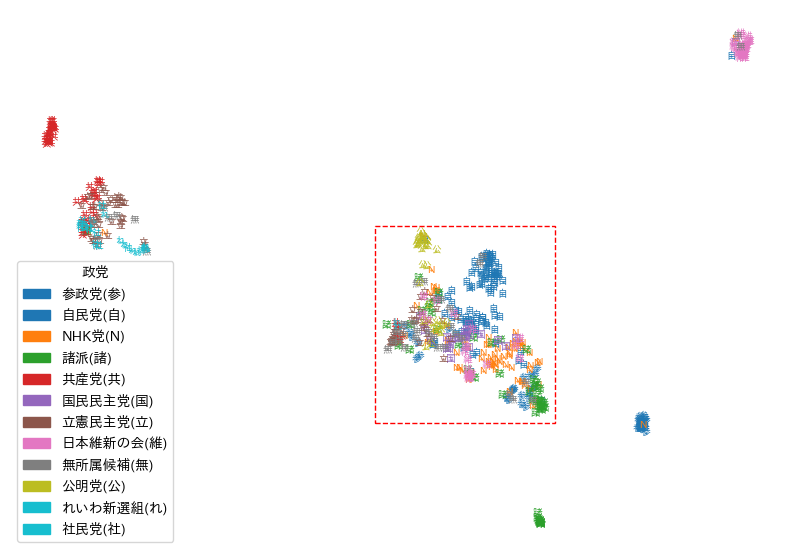

 
comment 37 : Q5_6いますぐ原子力発電を廃止すべきだ / 将来も原子力発電は電力源のひとつとして保つべきだ
## In-group: agree: 16.9% neutral: 28.0% disagree: 55.1% 63.0, 104.0, 205.0, (N=372.0)
## Out-group: agree: 60.2% neutral: 30.6% disagree: 9.3% 130.0, 66.0, 20.0, (N=216.0)
pvalue:  4.009862897718841e-29


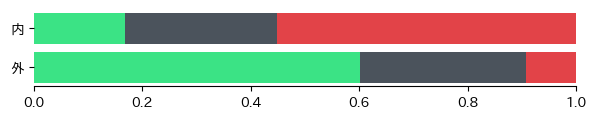

 
comment 16 : Q4_12時限的又は恒久的に消費税率を引き下げるべきだ
## In-group: agree: 57.8% neutral: 16.3% disagree: 26.0% 167.0, 47.0, 75.0, (N=289.0)
## Out-group: agree: 96.3% neutral: 2.8% disagree: 0.9% 208.0, 6.0, 2.0, (N=216.0)
pvalue:  1.674496534380174e-11


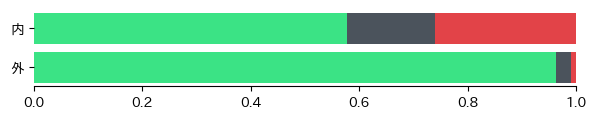

 
comment 27 : Q4_23被選挙権を得られる年齢を引き下げるべきだ
## In-group: agree: 47.2% neutral: 30.3% disagree: 22.4% 137.0, 88.0, 65.0, (N=290.0)
## Out-group: agree: 81.0% neutral: 13.9% disagree: 5.1% 175.0, 30.0, 11.0, (N=216.0)
pvalue:  0.00010999766489625612


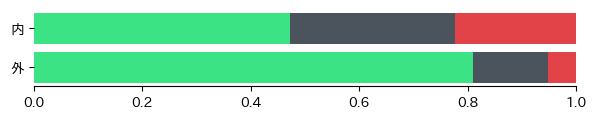

 
comment 40 : Q5_9一票の格差是正のためにも、参議院選挙区の「合区」は許容されるべきだ / 参議院選挙区の「合区」を解消するためにも、一定範囲内の一票の格差は許容されるべきだ
## In-group: agree: 27.1% neutral: 32.9% disagree: 40.0% 99.0, 120.0, 146.0, (N=365.0)
## Out-group: agree: 31.3% neutral: 45.3% disagree: 23.4% 67.0, 97.0, 50.0, (N=214.0)
pvalue:  0.00016300948522537787


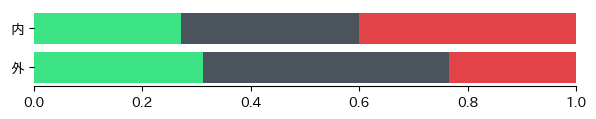

 
comment 22 : Q4_18永住外国人の地方参政権を認めるべきだ
## In-group: agree: 17.2% neutral: 17.6% disagree: 65.2% 50.0, 51.0, 189.0, (N=290.0)
## Out-group: agree: 52.3% neutral: 11.6% disagree: 36.1% 113.0, 25.0, 78.0, (N=216.0)
pvalue:  0.0019531041623482538


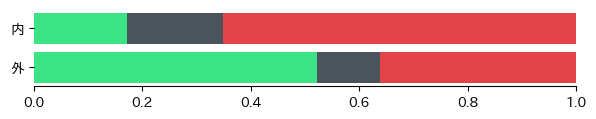

## Q5_6いますぐ原子力発電を廃止すべきだ / 将来も原子力発電は電力源のひとつとして保つべきだ
このグループ:  賛成: 17% 中立: 28% 反対: 55%
他のグループ:  賛成: 60% 中立: 31% 反対: 9%
他のクラスタより反対が多い

## Q4_12時限的又は恒久的に消費税率を引き下げるべきだ
このグループ:  賛成: 58% 中立: 16% 反対: 26%
他のグループ:  賛成: 96% 中立: 3% 反対: 1%
他のクラスタより反対が多い

## Q4_23被選挙権を得られる年齢を引き下げるべきだ
このグループ:  賛成: 47% 中立: 30% 反対: 22%
他のグループ:  賛成: 81% 中立: 14% 反対: 5%
他のクラスタより反対が多い

## Q5_9一票の格差是正のためにも、参議院選挙区の「合区」は許容されるべきだ / 参議院選挙区の「合区」を解消するためにも、一定範囲内の一票の格差は許容されるべきだ
このグループ:  賛成: 27% 中立: 33% 反対: 40%
他のグループ:  賛成: 31% 中立: 45% 反対: 23%
他のクラスタより反対が多い

## Q4_18永住外国人の地方参政権を認めるべきだ
このグループ:  賛成: 17% 中立: 18% 反対: 65%
他のグループ:  賛成: 52% 中立: 12% 反対: 36%
他のクラスタより反対が多い



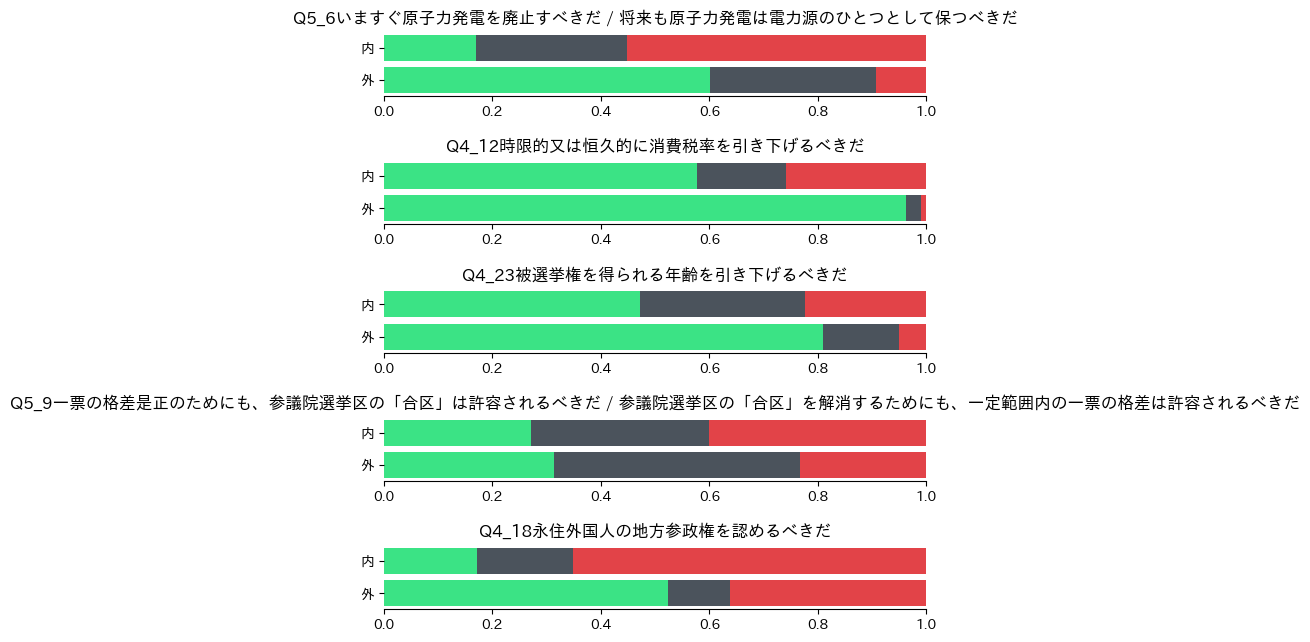

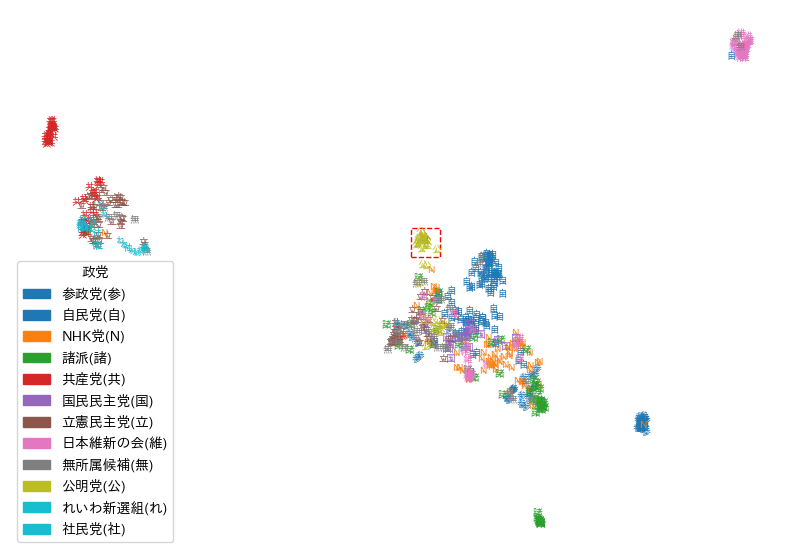

 
comment 16 : Q4_12時限的又は恒久的に消費税率を引き下げるべきだ
## In-group: agree: 0.0% neutral: 8.3% disagree: 91.7% 0.0, 2.0, 22.0, (N=24.0)
## Out-group: agree: 78.0% neutral: 10.6% disagree: 11.4% 375.0, 51.0, 55.0, (N=481.0)
pvalue:  1.9675340825958763e-16


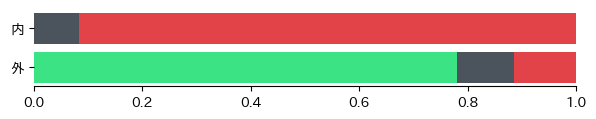

 
comment 23 : Q4_19治安を守るためにプライバシーや個人の権利が制約されるのは当然だ
## In-group: agree: 8.7% neutral: 17.4% disagree: 73.9% 2.0, 4.0, 17.0, (N=23.0)
## Out-group: agree: 18.6% neutral: 34.2% disagree: 47.2% 89.0, 164.0, 226.0, (N=479.0)
pvalue:  0.010519446418362067


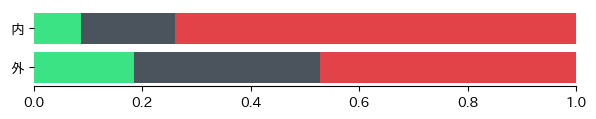

 
comment 26 : Q4_22感染症の拡大防止のため、ロックダウンのような強力な私権制限ができるように法改正すべきだ
## In-group: agree: 4.2% neutral: 20.8% disagree: 75.0% 1.0, 5.0, 18.0, (N=24.0)
## Out-group: agree: 27.5% neutral: 26.1% disagree: 46.4% 155.0, 147.0, 261.0, (N=563.0)
pvalue:  0.021184786819656673


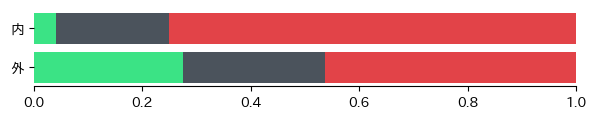

 
comment 41 : Q5_10与党所属の参議院議員は、入閣はせず第二院として独自の役割を担うべきだ / 与党所属の参議院議員も、入閣して政権運営を積極的に支えるべきだ
## In-group: agree: 4.2% neutral: 29.2% disagree: 66.7% 1.0, 7.0, 16.0, (N=24.0)
## Out-group: agree: 10.0% neutral: 42.5% disagree: 47.5% 48.0, 203.0, 227.0, (N=478.0)
pvalue:  0.027542746945936288


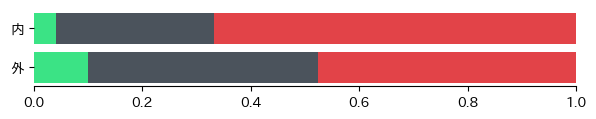

 
comment 22 : Q4_18永住外国人の地方参政権を認めるべきだ
## In-group: agree: 95.7% neutral: 4.3% disagree: 0.0% 22.0, 1.0, 0.0, (N=23.0)
## Out-group: agree: 29.2% neutral: 15.5% disagree: 55.3% 141.0, 75.0, 267.0, (N=483.0)
pvalue:  0.06374378109452734


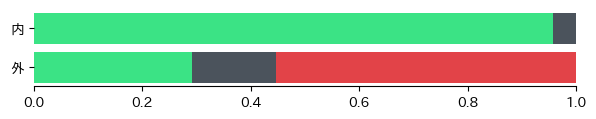

## Q4_12時限的又は恒久的に消費税率を引き下げるべきだ
このグループ:  賛成: 0% 中立: 8% 反対: 92%
他のグループ:  賛成: 78% 中立: 11% 反対: 11%
他のクラスタより反対が多い

## Q4_19治安を守るためにプライバシーや個人の権利が制約されるのは当然だ
このグループ:  賛成: 9% 中立: 17% 反対: 74%
他のグループ:  賛成: 19% 中立: 34% 反対: 47%
他のクラスタより反対が多い

## Q4_22感染症の拡大防止のため、ロックダウンのような強力な私権制限ができるように法改正すべきだ
このグループ:  賛成: 4% 中立: 21% 反対: 75%
他のグループ:  賛成: 28% 中立: 26% 反対: 46%
他のクラスタより反対が多い

## Q5_10与党所属の参議院議員は、入閣はせず第二院として独自の役割を担うべきだ / 与党所属の参議院議員も、入閣して政権運営を積極的に支えるべきだ
このグループ:  賛成: 4% 中立: 29% 反対: 67%
他のグループ:  賛成: 10% 中立: 42% 反対: 47%
他のクラスタより反対が多い

## Q4_18永住外国人の地方参政権を認めるべきだ
このグループ:  賛成: 96% 中立: 4% 反対: 0%
他のグループ:  賛成: 29% 中立: 16% 反対: 55%
他のクラスタより賛成が多い



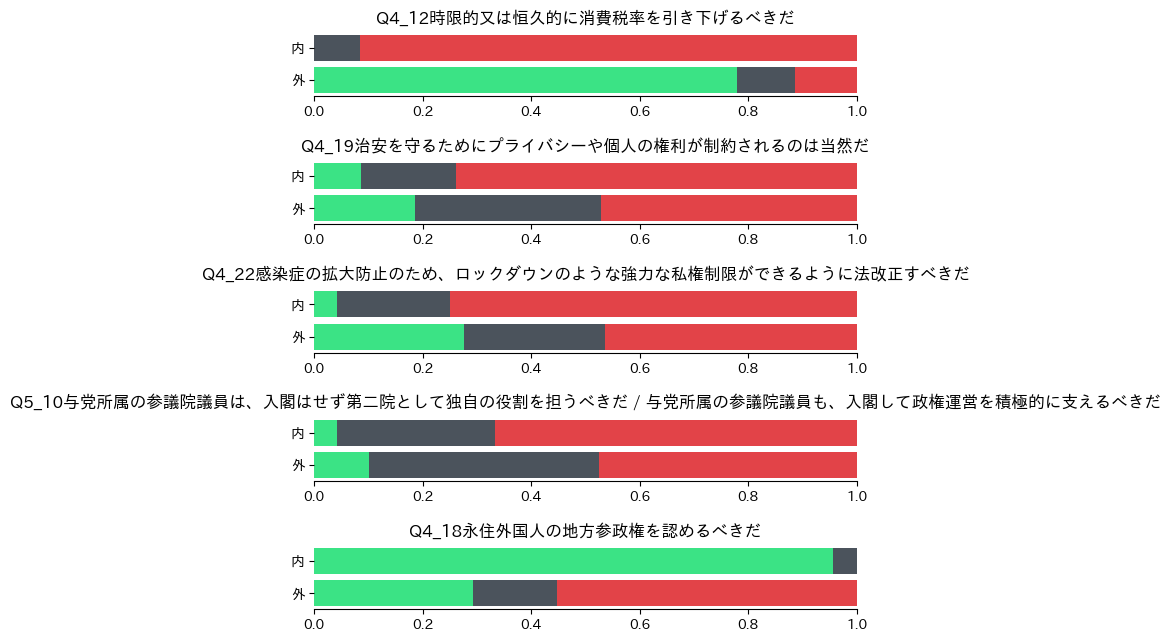

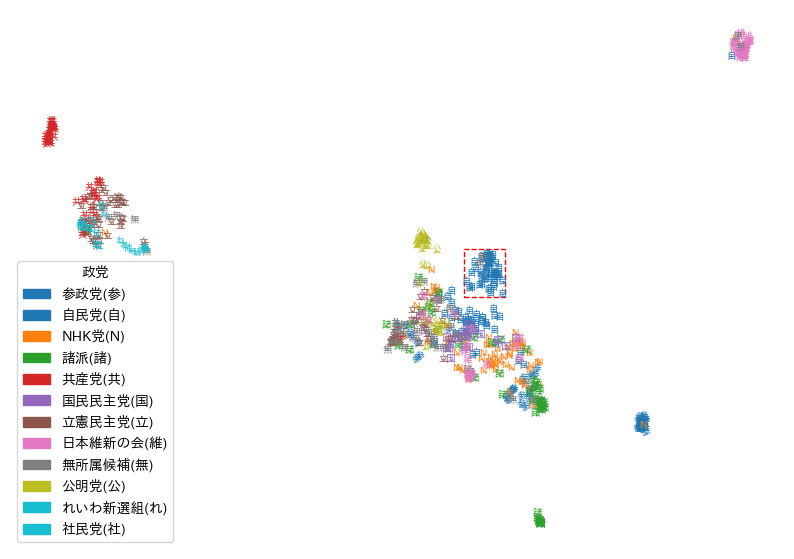

 
comment 16 : Q4_12時限的又は恒久的に消費税率を引き下げるべきだ
## In-group: agree: 2.0% neutral: 26.0% disagree: 72.0% 1.0, 13.0, 36.0, (N=50.0)
## Out-group: agree: 82.2% neutral: 8.8% disagree: 9.0% 374.0, 40.0, 41.0, (N=455.0)
pvalue:  1.7882664253356443e-22


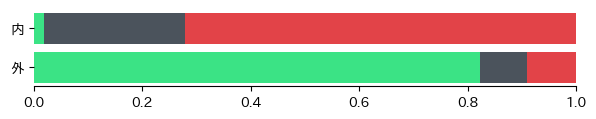

 
comment 40 : Q5_9一票の格差是正のためにも、参議院選挙区の「合区」は許容されるべきだ / 参議院選挙区の「合区」を解消するためにも、一定範囲内の一票の格差は許容されるべきだ
## In-group: agree: 4.0% neutral: 14.0% disagree: 82.0% 2.0, 7.0, 41.0, (N=50.0)
## Out-group: agree: 31.0% neutral: 39.7% disagree: 29.3% 164.0, 210.0, 155.0, (N=529.0)
pvalue:  2.5574681662142645e-12


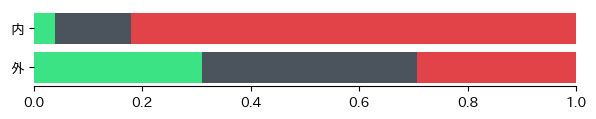

 
comment 37 : Q5_6いますぐ原子力発電を廃止すべきだ / 将来も原子力発電は電力源のひとつとして保つべきだ
## In-group: agree: 0.0% neutral: 12.2% disagree: 87.8% 0.0, 6.0, 43.0, (N=49.0)
## Out-group: agree: 35.8% neutral: 30.4% disagree: 33.8% 193.0, 164.0, 182.0, (N=539.0)
pvalue:  7.693725846038799e-12


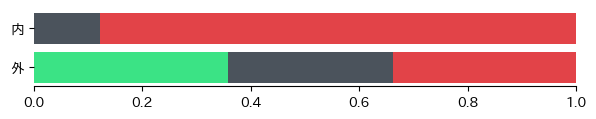

 
comment 22 : Q4_18永住外国人の地方参政権を認めるべきだ
## In-group: agree: 0.0% neutral: 12.0% disagree: 88.0% 0.0, 6.0, 44.0, (N=50.0)
## Out-group: agree: 35.7% neutral: 15.4% disagree: 48.9% 163.0, 70.0, 223.0, (N=456.0)
pvalue:  8.490681678622456e-10


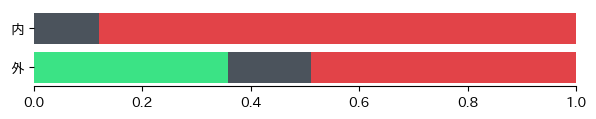

 
comment 41 : Q5_10与党所属の参議院議員は、入閣はせず第二院として独自の役割を担うべきだ / 与党所属の参議院議員も、入閣して政権運営を積極的に支えるべきだ
## In-group: agree: 0.0% neutral: 22.0% disagree: 78.0% 0.0, 11.0, 39.0, (N=50.0)
## Out-group: agree: 10.8% neutral: 44.0% disagree: 45.1% 49.0, 199.0, 204.0, (N=452.0)
pvalue:  2.0972881856015479e-07


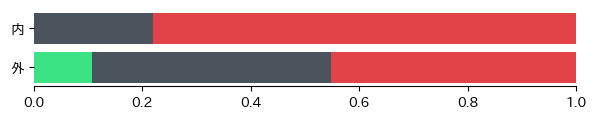

## Q4_12時限的又は恒久的に消費税率を引き下げるべきだ
このグループ:  賛成: 2% 中立: 26% 反対: 72%
他のグループ:  賛成: 82% 中立: 9% 反対: 9%
他のクラスタより反対が多い

## Q5_9一票の格差是正のためにも、参議院選挙区の「合区」は許容されるべきだ / 参議院選挙区の「合区」を解消するためにも、一定範囲内の一票の格差は許容されるべきだ
このグループ:  賛成: 4% 中立: 14% 反対: 82%
他のグループ:  賛成: 31% 中立: 40% 反対: 29%
他のクラスタより反対が多い

## Q5_6いますぐ原子力発電を廃止すべきだ / 将来も原子力発電は電力源のひとつとして保つべきだ
このグループ:  賛成: 0% 中立: 12% 反対: 88%
他のグループ:  賛成: 36% 中立: 30% 反対: 34%
他のクラスタより反対が多い

## Q4_18永住外国人の地方参政権を認めるべきだ
このグループ:  賛成: 0% 中立: 12% 反対: 88%
他のグループ:  賛成: 36% 中立: 15% 反対: 49%
他のクラスタより反対が多い

## Q5_10与党所属の参議院議員は、入閣はせず第二院として独自の役割を担うべきだ / 与党所属の参議院議員も、入閣して政権運営を積極的に支えるべきだ
このグループ:  賛成: 0% 中立: 22% 反対: 78%
他のグループ:  賛成: 11% 中立: 44% 反対: 45%
他のクラスタより反対が多い



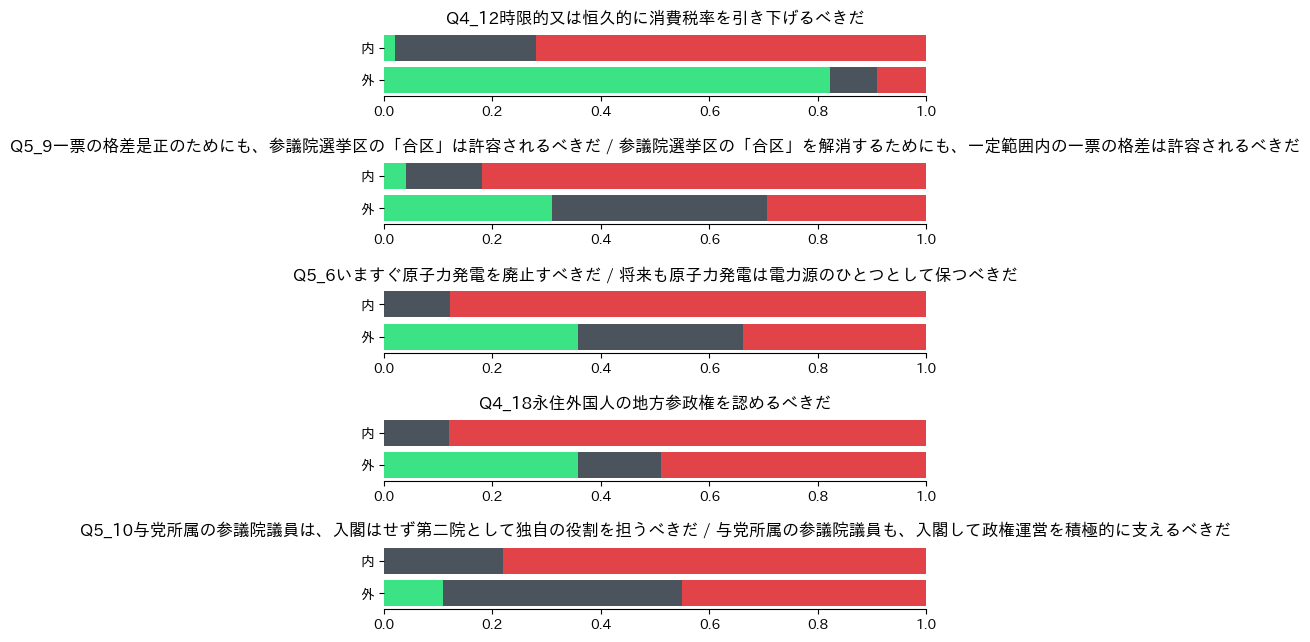

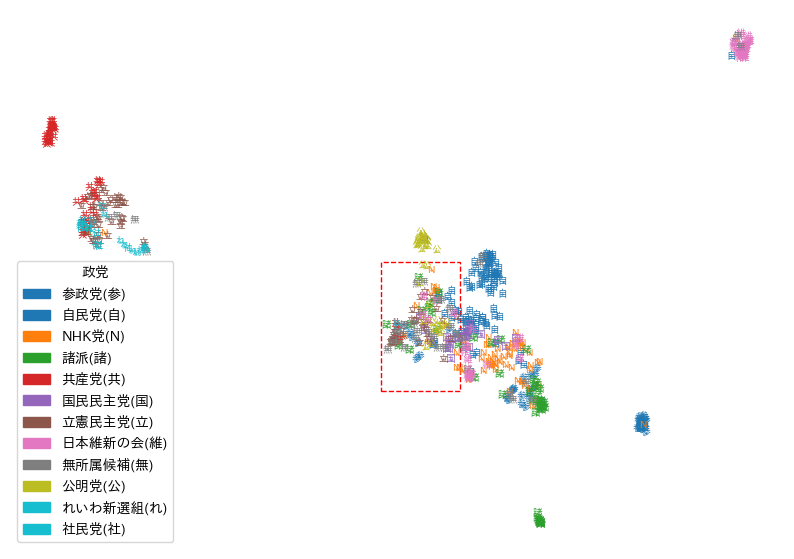

 
comment 7 : Q4_3北朝鮮に対しては対話よりも圧力を優先すべきだ
## In-group: agree: 18.7% neutral: 43.2% disagree: 38.1% 26.0, 60.0, 53.0, (N=139.0)
## Out-group: agree: 55.0% neutral: 28.6% disagree: 16.3% 246.0, 128.0, 73.0, (N=447.0)
pvalue:  9.209440900816507e-07


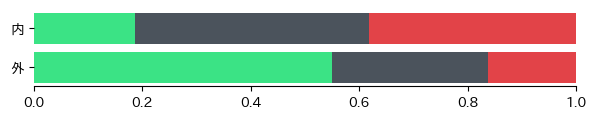

 
comment 6 : Q4_2他国からの攻撃が予想される場合には敵基地攻撃もためらうべきではない
## In-group: agree: 7.3% neutral: 36.5% disagree: 56.2% 10.0, 50.0, 77.0, (N=137.0)
## Out-group: agree: 58.1% neutral: 10.7% disagree: 31.2% 261.0, 48.0, 140.0, (N=449.0)
pvalue:  1.362460889836861e-06


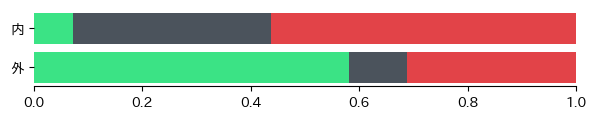

 
comment 8 : Q4_4ロシアに対しては対話よりも圧力を優先すべきだ
## In-group: agree: 24.5% neutral: 42.4% disagree: 33.1% 34.0, 59.0, 46.0, (N=139.0)
## Out-group: agree: 47.9% neutral: 33.3% disagree: 18.8% 214.0, 149.0, 84.0, (N=447.0)
pvalue:  0.0014586467238863832


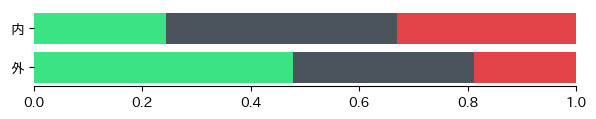

 
comment 26 : Q4_22感染症の拡大防止のため、ロックダウンのような強力な私権制限ができるように法改正すべきだ
## In-group: agree: 11.6% neutral: 34.1% disagree: 54.3% 16.0, 47.0, 75.0, (N=138.0)
## Out-group: agree: 31.2% neutral: 23.4% disagree: 45.4% 140.0, 105.0, 204.0, (N=449.0)
pvalue:  0.08325903573164992


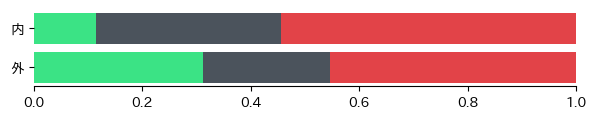

## Q4_3北朝鮮に対しては対話よりも圧力を優先すべきだ
このグループ:  賛成: 19% 中立: 43% 反対: 38%
他のグループ:  賛成: 55% 中立: 29% 反対: 16%
他のクラスタより反対が多い

## Q4_2他国からの攻撃が予想される場合には敵基地攻撃もためらうべきではない
このグループ:  賛成: 7% 中立: 36% 反対: 56%
他のグループ:  賛成: 58% 中立: 11% 反対: 31%
他のクラスタより反対が多い

## Q4_4ロシアに対しては対話よりも圧力を優先すべきだ
このグループ:  賛成: 24% 中立: 42% 反対: 33%
他のグループ:  賛成: 48% 中立: 33% 反対: 19%
他のクラスタより反対が多い

## Q4_22感染症の拡大防止のため、ロックダウンのような強力な私権制限ができるように法改正すべきだ
このグループ:  賛成: 12% 中立: 34% 反対: 54%
他のグループ:  賛成: 31% 中立: 23% 反対: 45%
他のクラスタより反対が多い



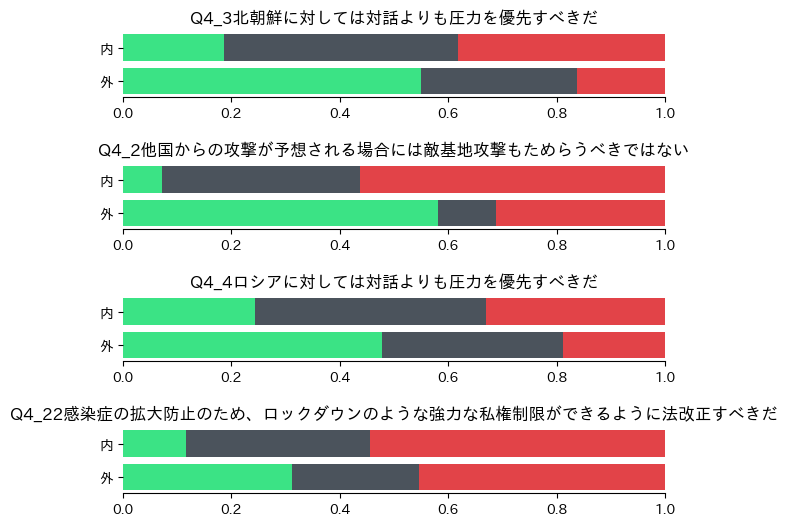

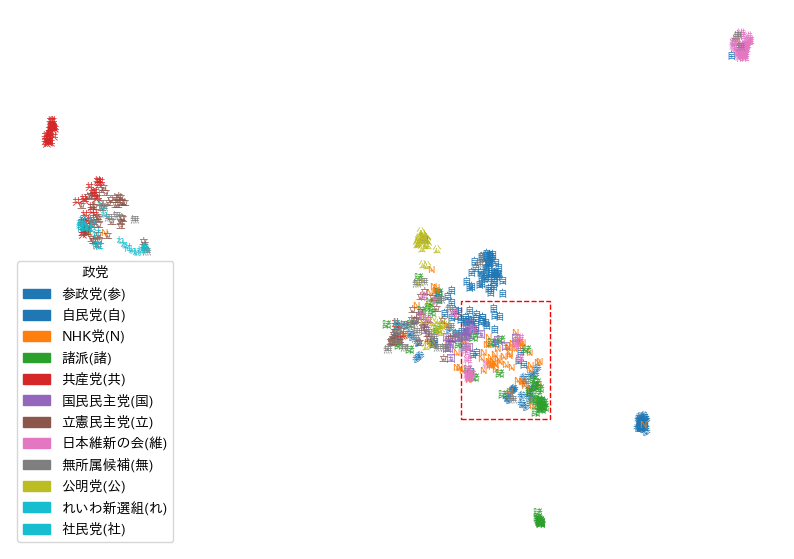

 
comment 37 : Q5_6いますぐ原子力発電を廃止すべきだ / 将来も原子力発電は電力源のひとつとして保つべきだ
## In-group: agree: 3.8% neutral: 20.6% disagree: 75.6% 6.0, 33.0, 121.0, (N=160.0)
## Out-group: agree: 43.7% neutral: 32.0% disagree: 24.3% 187.0, 137.0, 104.0, (N=428.0)
pvalue:  2.035760646607997e-28


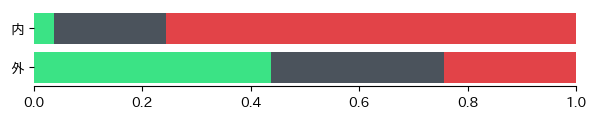

 
comment 21 : Q4_17外国人労働者の受け入れを進めるべきだ
## In-group: agree: 12.0% neutral: 18.0% disagree: 69.9% 16.0, 24.0, 93.0, (N=133.0)
## Out-group: agree: 52.7% neutral: 33.2% disagree: 14.2% 197.0, 124.0, 53.0, (N=374.0)
pvalue:  2.481480273750283e-26


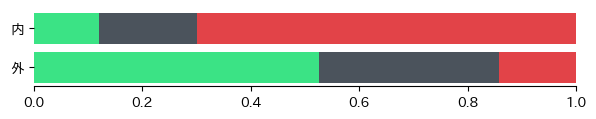

 
comment 9 : Q4_5非核三原則を堅持すべきだ
## In-group: agree: 18.4% neutral: 26.6% disagree: 55.1% 29.0, 42.0, 87.0, (N=158.0)
## Out-group: agree: 72.4% neutral: 16.5% disagree: 11.1% 312.0, 71.0, 48.0, (N=431.0)
pvalue:  2.171394829267447e-24


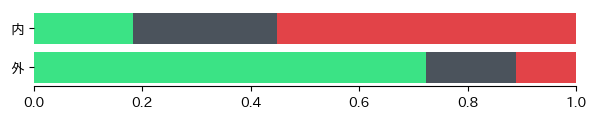

 
comment 39 : Q5_8気候変動問題に対応するため、生活水準を犠牲にすることも必要だ / 生活水準を犠牲にするほど、気候変動問題への対応は重要問題ではない
## In-group: agree: 17.8% neutral: 29.9% disagree: 52.2% 28.0, 47.0, 82.0, (N=157.0)
## Out-group: agree: 38.1% neutral: 46.0% disagree: 16.0% 160.0, 193.0, 67.0, (N=420.0)
pvalue:  2.757861961805419e-16


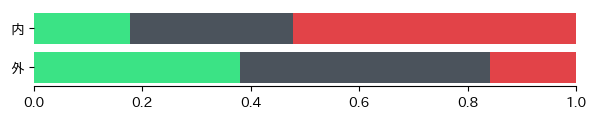

 
comment 31 : Q4_27国会議員の議席や候補者の一定割合を女性に割り当てるクオータ制を導入すべきだ
## In-group: agree: 22.4% neutral: 25.0% disagree: 52.6% 35.0, 39.0, 82.0, (N=156.0)
## Out-group: agree: 55.8% neutral: 26.2% disagree: 18.0% 239.0, 112.0, 77.0, (N=428.0)
pvalue:  7.391467790534269e-14


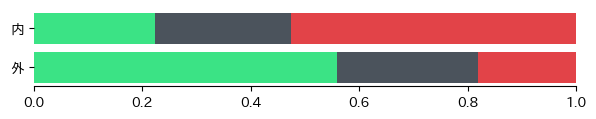

## Q5_6いますぐ原子力発電を廃止すべきだ / 将来も原子力発電は電力源のひとつとして保つべきだ
このグループ:  賛成: 4% 中立: 21% 反対: 76%
他のグループ:  賛成: 44% 中立: 32% 反対: 24%
他のクラスタより反対が多い

## Q4_17外国人労働者の受け入れを進めるべきだ
このグループ:  賛成: 12% 中立: 18% 反対: 70%
他のグループ:  賛成: 53% 中立: 33% 反対: 14%
他のクラスタより反対が多い

## Q4_5非核三原則を堅持すべきだ
このグループ:  賛成: 18% 中立: 27% 反対: 55%
他のグループ:  賛成: 72% 中立: 16% 反対: 11%
他のクラスタより反対が多い

## Q5_8気候変動問題に対応するため、生活水準を犠牲にすることも必要だ / 生活水準を犠牲にするほど、気候変動問題への対応は重要問題ではない
このグループ:  賛成: 18% 中立: 30% 反対: 52%
他のグループ:  賛成: 38% 中立: 46% 反対: 16%
他のクラスタより反対が多い

## Q4_27国会議員の議席や候補者の一定割合を女性に割り当てるクオータ制を導入すべきだ
このグループ:  賛成: 22% 中立: 25% 反対: 53%
他のグループ:  賛成: 56% 中立: 26% 反対: 18%
他のクラスタより反対が多い



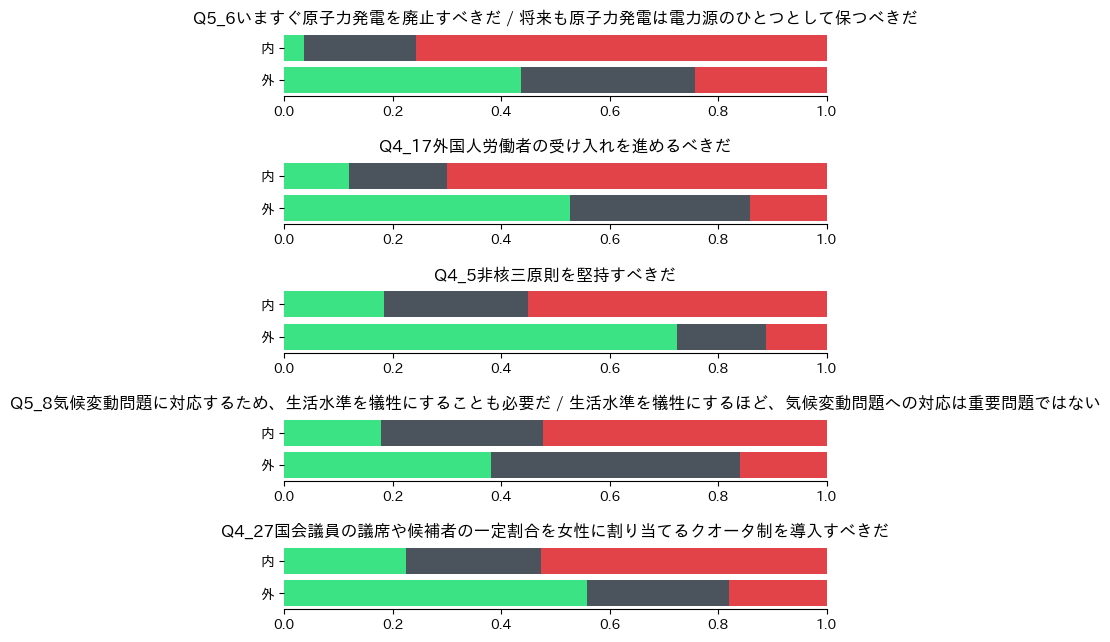

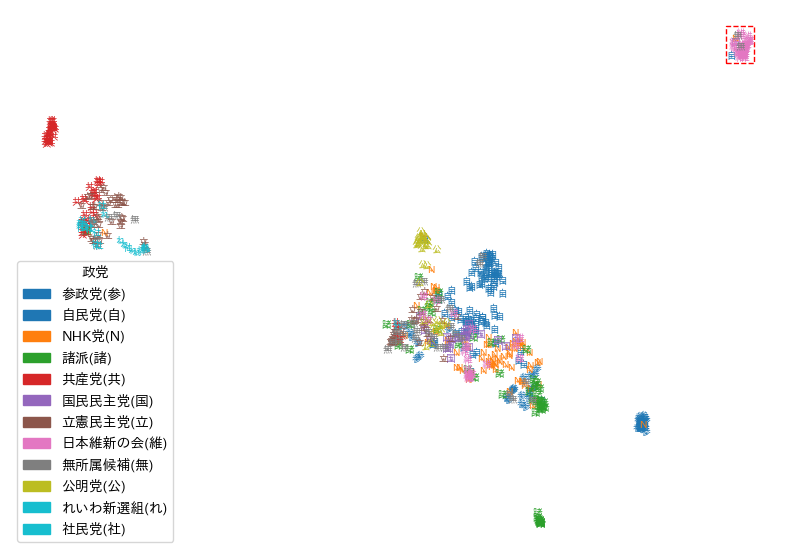

 
comment 14 : Q4_10公共事業による雇用確保は必要だ
## In-group: agree: 4.9% neutral: 9.8% disagree: 85.4% 2.0, 4.0, 35.0, (N=41.0)
## Out-group: agree: 72.2% neutral: 19.4% disagree: 8.4% 335.0, 90.0, 39.0, (N=464.0)
pvalue:  6.888510545020636e-27


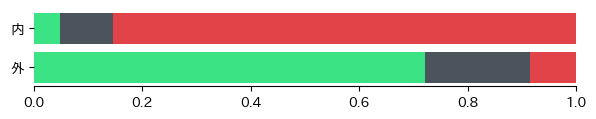

 
comment 35 : Q5_4国内産業を保護すべきだ / 貿易や投資の自由化を進めるべきだ
## In-group: agree: 2.4% neutral: 12.2% disagree: 85.4% 1.0, 5.0, 35.0, (N=41.0)
## Out-group: agree: 66.3% neutral: 23.8% disagree: 9.9% 307.0, 110.0, 46.0, (N=463.0)
pvalue:  2.862568613903103e-25


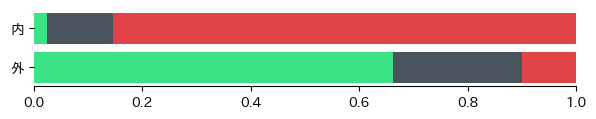

 
comment 18 : Q4_14企業が納めている法人税率を引き上げるべきだ
## In-group: agree: 2.4% neutral: 4.9% disagree: 92.7% 1.0, 2.0, 38.0, (N=41.0)
## Out-group: agree: 45.3% neutral: 30.0% disagree: 24.8% 210.0, 139.0, 115.0, (N=464.0)
pvalue:  5.399797343250761e-19


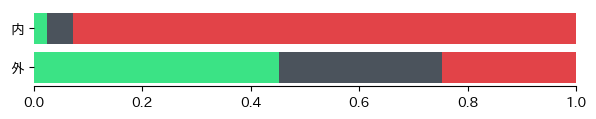

 
comment 22 : Q4_18永住外国人の地方参政権を認めるべきだ
## In-group: agree: 0.0% neutral: 4.9% disagree: 95.1% 0.0, 2.0, 39.0, (N=41.0)
## Out-group: agree: 35.1% neutral: 15.9% disagree: 49.0% 163.0, 74.0, 228.0, (N=465.0)
pvalue:  5.8071932088975e-11


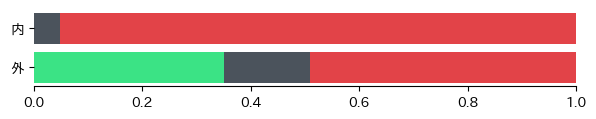

 
comment 41 : Q5_10与党所属の参議院議員は、入閣はせず第二院として独自の役割を担うべきだ / 与党所属の参議院議員も、入閣して政権運営を積極的に支えるべきだ
## In-group: agree: 2.4% neutral: 9.8% disagree: 87.8% 1.0, 4.0, 36.0, (N=41.0)
## Out-group: agree: 10.4% neutral: 44.7% disagree: 44.9% 48.0, 206.0, 207.0, (N=461.0)
pvalue:  2.159449247899014e-09


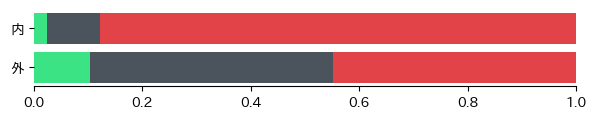

## Q4_10公共事業による雇用確保は必要だ
このグループ:  賛成: 5% 中立: 10% 反対: 85%
他のグループ:  賛成: 72% 中立: 19% 反対: 8%
他のクラスタより反対が多い

## Q5_4国内産業を保護すべきだ / 貿易や投資の自由化を進めるべきだ
このグループ:  賛成: 2% 中立: 12% 反対: 85%
他のグループ:  賛成: 66% 中立: 24% 反対: 10%
他のクラスタより反対が多い

## Q4_14企業が納めている法人税率を引き上げるべきだ
このグループ:  賛成: 2% 中立: 5% 反対: 93%
他のグループ:  賛成: 45% 中立: 30% 反対: 25%
他のクラスタより反対が多い

## Q4_18永住外国人の地方参政権を認めるべきだ
このグループ:  賛成: 0% 中立: 5% 反対: 95%
他のグループ:  賛成: 35% 中立: 16% 反対: 49%
他のクラスタより反対が多い

## Q5_10与党所属の参議院議員は、入閣はせず第二院として独自の役割を担うべきだ / 与党所属の参議院議員も、入閣して政権運営を積極的に支えるべきだ
このグループ:  賛成: 2% 中立: 10% 反対: 88%
他のグループ:  賛成: 10% 中立: 45% 反対: 45%
他のクラスタより反対が多い



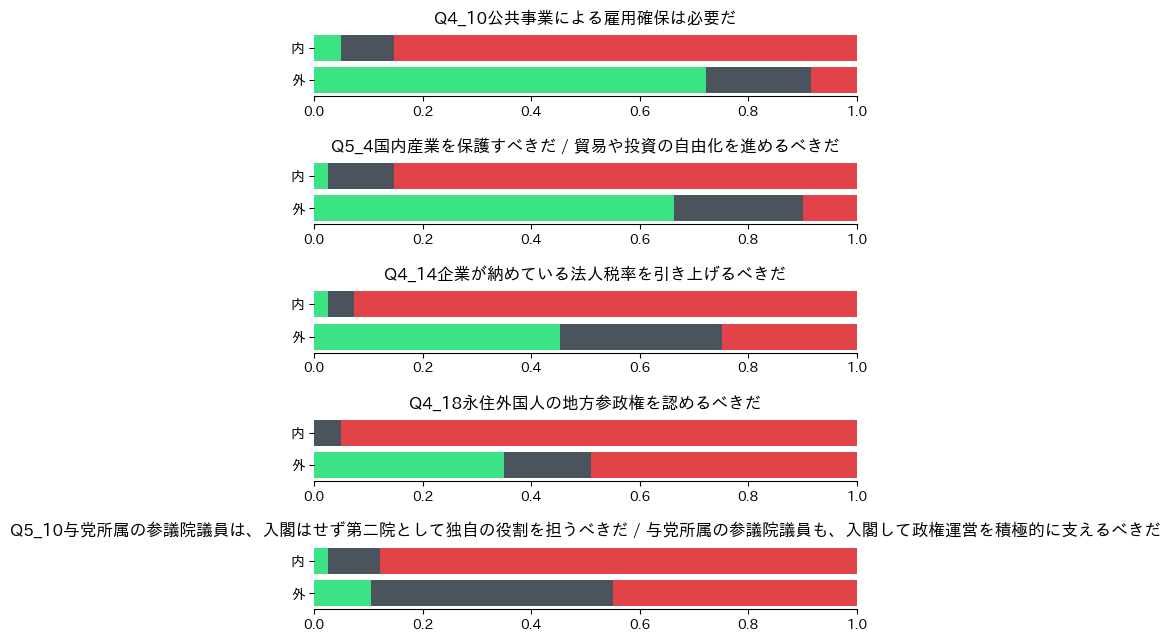

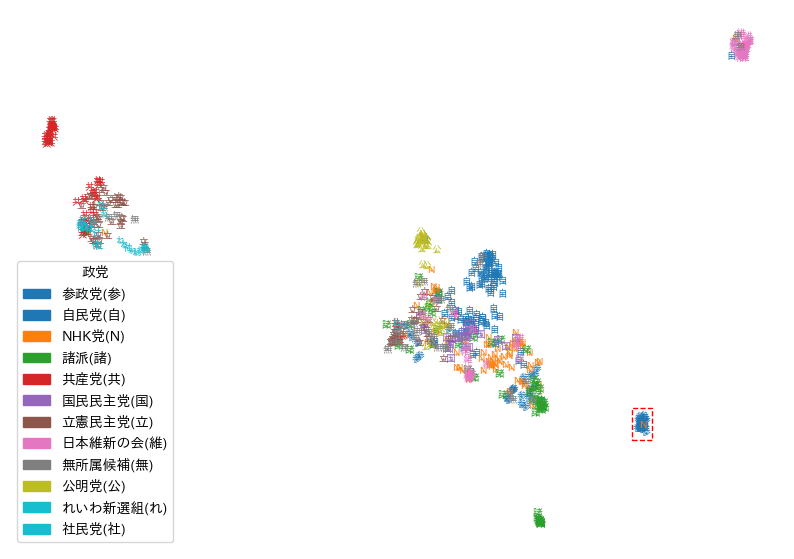

 
comment 20 : Q4_16大学や専門学校などの高等教育を無償化すべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 29.0, (N=29.0)
## Out-group: agree: 74.4% neutral: 14.3% disagree: 11.3% 354.0, 68.0, 54.0, (N=476.0)
pvalue:  2.671456224416124e-24


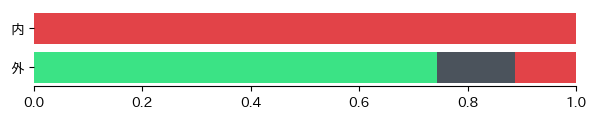

 
comment 17 : Q4_13所得や資産の多い人に対する課税を強化すべきだ
## In-group: agree: 0.0% neutral: 6.9% disagree: 93.1% 0.0, 2.0, 27.0, (N=29.0)
## Out-group: agree: 58.9% neutral: 27.0% disagree: 14.1% 279.0, 128.0, 67.0, (N=474.0)
pvalue:  7.9364330450393725e-19


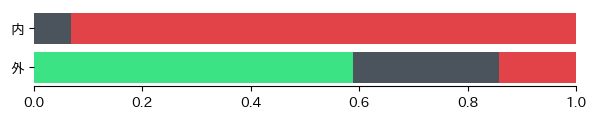

 
comment 9 : Q4_5非核三原則を堅持すべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 29.0, (N=29.0)
## Out-group: agree: 60.9% neutral: 20.2% disagree: 18.9% 341.0, 113.0, 106.0, (N=560.0)
pvalue:  9.571827349370825e-18


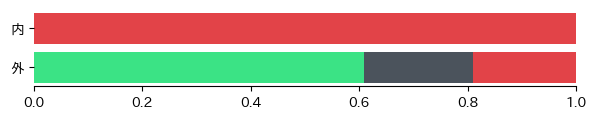

 
comment 29 : Q4_25男性同士、女性同士の結婚を法律で認めるべきだ
## In-group: agree: 0.0% neutral: 3.4% disagree: 96.6% 0.0, 1.0, 28.0, (N=29.0)
## Out-group: agree: 61.3% neutral: 18.9% disagree: 19.7% 292.0, 90.0, 94.0, (N=476.0)
pvalue:  2.7562264019937984e-17


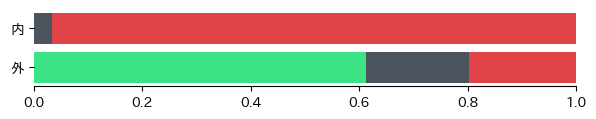

 
comment 21 : Q4_17外国人労働者の受け入れを進めるべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 29.0, (N=29.0)
## Out-group: agree: 44.6% neutral: 31.0% disagree: 24.5% 213.0, 148.0, 117.0, (N=478.0)
pvalue:  7.169292268707513e-17


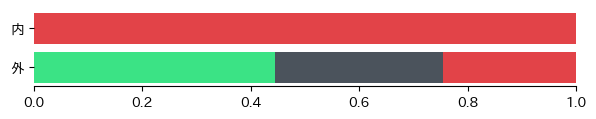

## Q4_16大学や専門学校などの高等教育を無償化すべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 74% 中立: 14% 反対: 11%
他のクラスタより反対が多い

## Q4_13所得や資産の多い人に対する課税を強化すべきだ
このグループ:  賛成: 0% 中立: 7% 反対: 93%
他のグループ:  賛成: 59% 中立: 27% 反対: 14%
他のクラスタより反対が多い

## Q4_5非核三原則を堅持すべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 61% 中立: 20% 反対: 19%
他のクラスタより反対が多い

## Q4_25男性同士、女性同士の結婚を法律で認めるべきだ
このグループ:  賛成: 0% 中立: 3% 反対: 97%
他のグループ:  賛成: 61% 中立: 19% 反対: 20%
他のクラスタより反対が多い

## Q4_17外国人労働者の受け入れを進めるべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 45% 中立: 31% 反対: 24%
他のクラスタより反対が多い



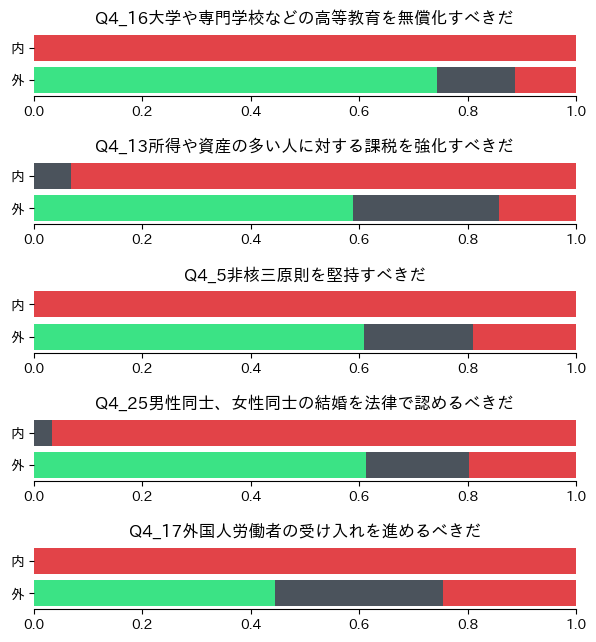

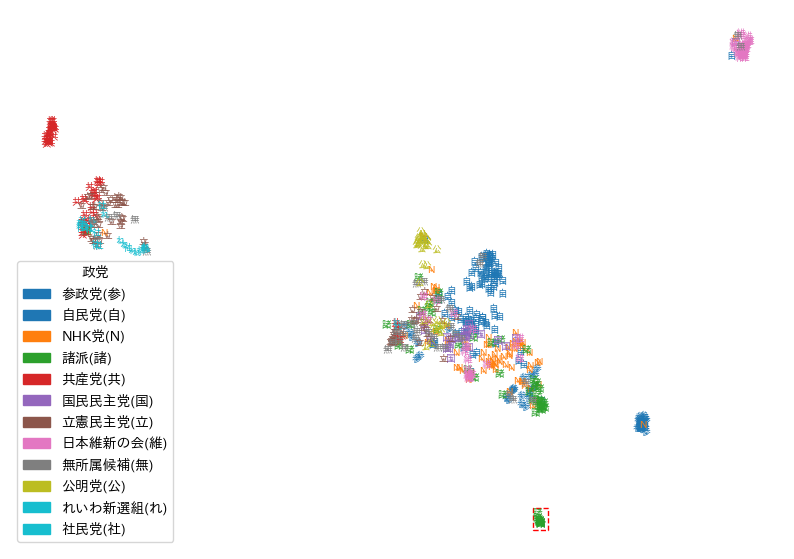

 
comment 15 : Q4_11当面は財政再建のために歳出を抑えるのではなく、景気対策のために財政出動を行うべきだ
## In-group: agree: 0.0% neutral: 16.7% disagree: 83.3% 0.0, 2.0, 10.0, (N=12.0)
## Out-group: agree: 83.3% neutral: 13.8% disagree: 3.0% 478.0, 79.0, 17.0, (N=574.0)
pvalue:  1.0357099233146848e-09


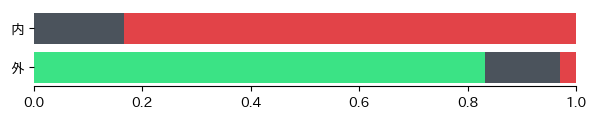

 
comment 30 : Q4_26LGBTなど性的少数者をめぐる「理解増進」法案を早期に成立させるべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 12.0, (N=12.0)
## Out-group: agree: 63.5% neutral: 24.2% disagree: 12.3% 310.0, 118.0, 60.0, (N=488.0)
pvalue:  2.59898142248075e-09


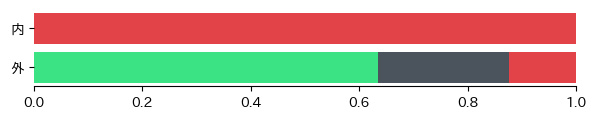

 
comment 20 : Q4_16大学や専門学校などの高等教育を無償化すべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 12.0, (N=12.0)
## Out-group: agree: 71.8% neutral: 13.8% disagree: 14.4% 354.0, 68.0, 71.0, (N=493.0)
pvalue:  1.3239819161393337e-08


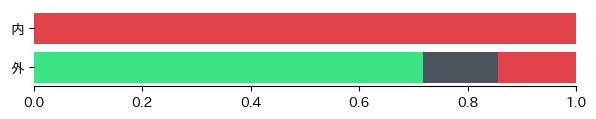

 
comment 17 : Q4_13所得や資産の多い人に対する課税を強化すべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 12.0, (N=12.0)
## Out-group: agree: 56.8% neutral: 26.5% disagree: 16.7% 279.0, 130.0, 82.0, (N=491.0)
pvalue:  4.09439751642314e-08


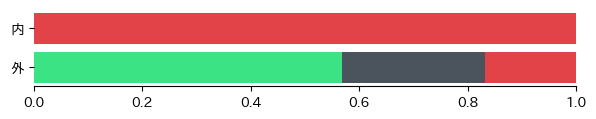

 
comment 29 : Q4_25男性同士、女性同士の結婚を法律で認めるべきだ
## In-group: agree: 0.0% neutral: 0.0% disagree: 100.0% 0.0, 0.0, 12.0, (N=12.0)
## Out-group: agree: 59.2% neutral: 18.5% disagree: 22.3% 292.0, 91.0, 110.0, (N=493.0)
pvalue:  6.573392617706591e-07


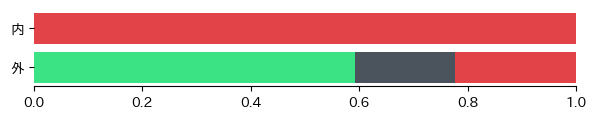

## Q4_11当面は財政再建のために歳出を抑えるのではなく、景気対策のために財政出動を行うべきだ
このグループ:  賛成: 0% 中立: 17% 反対: 83%
他のグループ:  賛成: 83% 中立: 14% 反対: 3%
他のクラスタより反対が多い

## Q4_26LGBTなど性的少数者をめぐる「理解増進」法案を早期に成立させるべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 64% 中立: 24% 反対: 12%
他のクラスタより反対が多い

## Q4_16大学や専門学校などの高等教育を無償化すべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 72% 中立: 14% 反対: 14%
他のクラスタより反対が多い

## Q4_13所得や資産の多い人に対する課税を強化すべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 57% 中立: 26% 反対: 17%
他のクラスタより反対が多い

## Q4_25男性同士、女性同士の結婚を法律で認めるべきだ
このグループ:  賛成: 0% 中立: 0% 反対: 100%
他のグループ:  賛成: 59% 中立: 18% 反対: 22%
他のクラスタより反対が多い



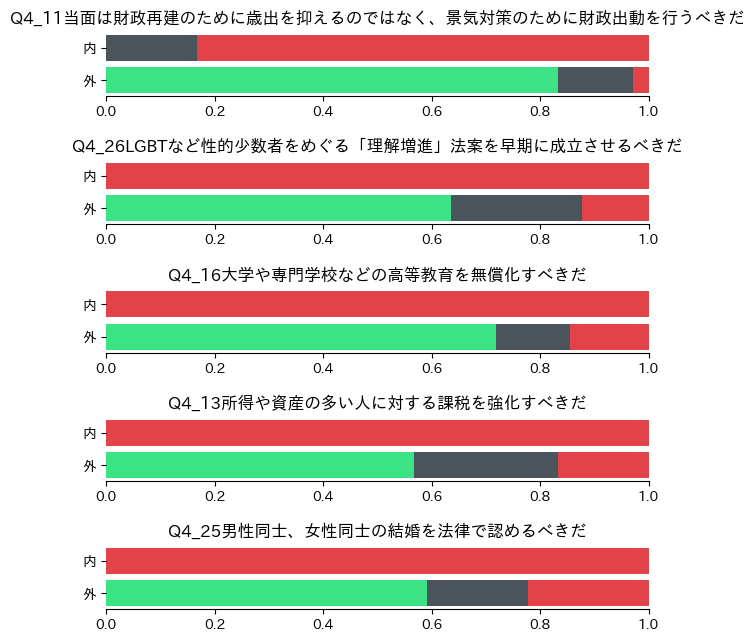

In [69]:
for g in selected_ranges:
    show_selected_ranges([g])
    clusters = np.zeros(len(cluster_mappings))
    x_min, x_max, y_min, y_max = g
    for row in merged_data.iterrows():
        idx = row[0]
        x, y = row[1]["UMAP1"], row[1]["UMAP2"]
        if x_min <= x <= x_max and y_min <= y <= y_max:
            clusters[idx] = 1

    p_values, total_vote_counts, N_v_g_c = representing_stat(matrix, clusters)
    show_representing_comments(p_values, total_vote_counts, N_v_g_c)


# Kernel Density Estimation

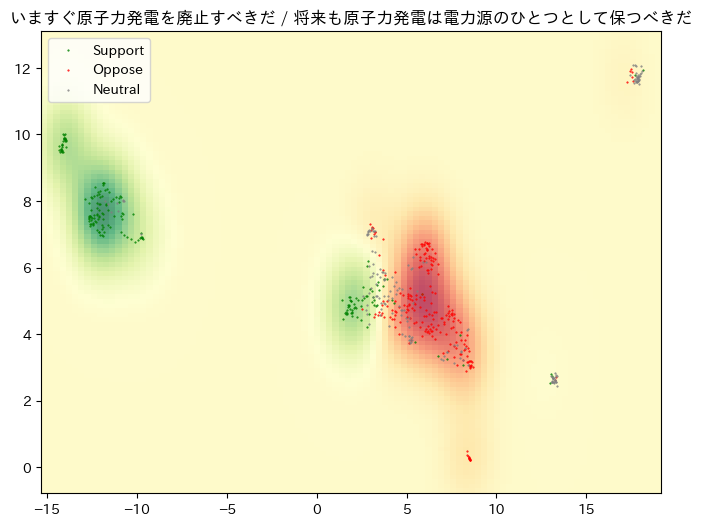

In [133]:
import textwrap

def contour(qid="Q5_6", ax=None, show_legend=True):
    from sklearn.neighbors import KernelDensity
    if not ax:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
    # データ準備
    X = umap_df[["UMAP1", "UMAP2"]].values
    values = matrix[qid][umap_df["User_ID"]].values

    # 賛成（+1）のデータと反対（-1）のデータに分割
    X_support = X[values == 1]
    X_oppose = X[values == -1]

    # グリッドの設定
    x_grid = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
    y_grid = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    grid_samples = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

    # KDEを使用して賛成データの密度推定
    bandwidth=1.0
    kde_support = KernelDensity(bandwidth=bandwidth, kernel="gaussian")
    kde_support.fit(X_support)
    log_density_support = kde_support.score_samples(grid_samples)
    density_support = np.exp(log_density_support).reshape(X_grid.shape)

    # KDEを使用して反対データの密度推定
    kde_oppose = KernelDensity(bandwidth=bandwidth, kernel="gaussian")
    kde_oppose.fit(X_oppose)
    log_density_oppose = kde_oppose.score_samples(grid_samples)
    density_oppose = np.exp(log_density_oppose).reshape(X_grid.shape)

    # 賛成と反対の密度差を計算
    density_diff = density_support - density_oppose

    # 密度差を等高線プロット
    # plt.contourf(X_grid, Y_grid, density_diff, cmap="RdYlGn", levels=20, alpha=0.7)
    ax.imshow(density_diff, extent=(x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()),
            origin="lower", cmap="RdYlGn", alpha=0.7, aspect="auto")

    # plt.colorbar(label="Density Difference (Support - Oppose)")

    # 散布図
    ax.scatter(X[values == 1, 0], X[values == 1, 1], c="green", label="Support",  s=1, marker=".")
    ax.scatter(X[values == -1, 0], X[values == -1, 1], c="red", label="Oppose",  s=1, marker=".")
    ax.scatter(X[values == 0, 0], X[values == 0, 1], c="gray", label="Neutral",  s=1, marker=".")

    # 軸ラベルとタイトル
    if show_legend:
        ax.set_title(readable[qid])
    else:
        # 長い質問文を幅指定で自動改行
        wrapped_title = "\n".join(textwrap.wrap(readable[qid], width=20))
        ax.set_title(wrapped_title, fontsize=8)  # フォントサイズも調整可能

    if show_legend:
        ax.legend()

contour()
plt.show()


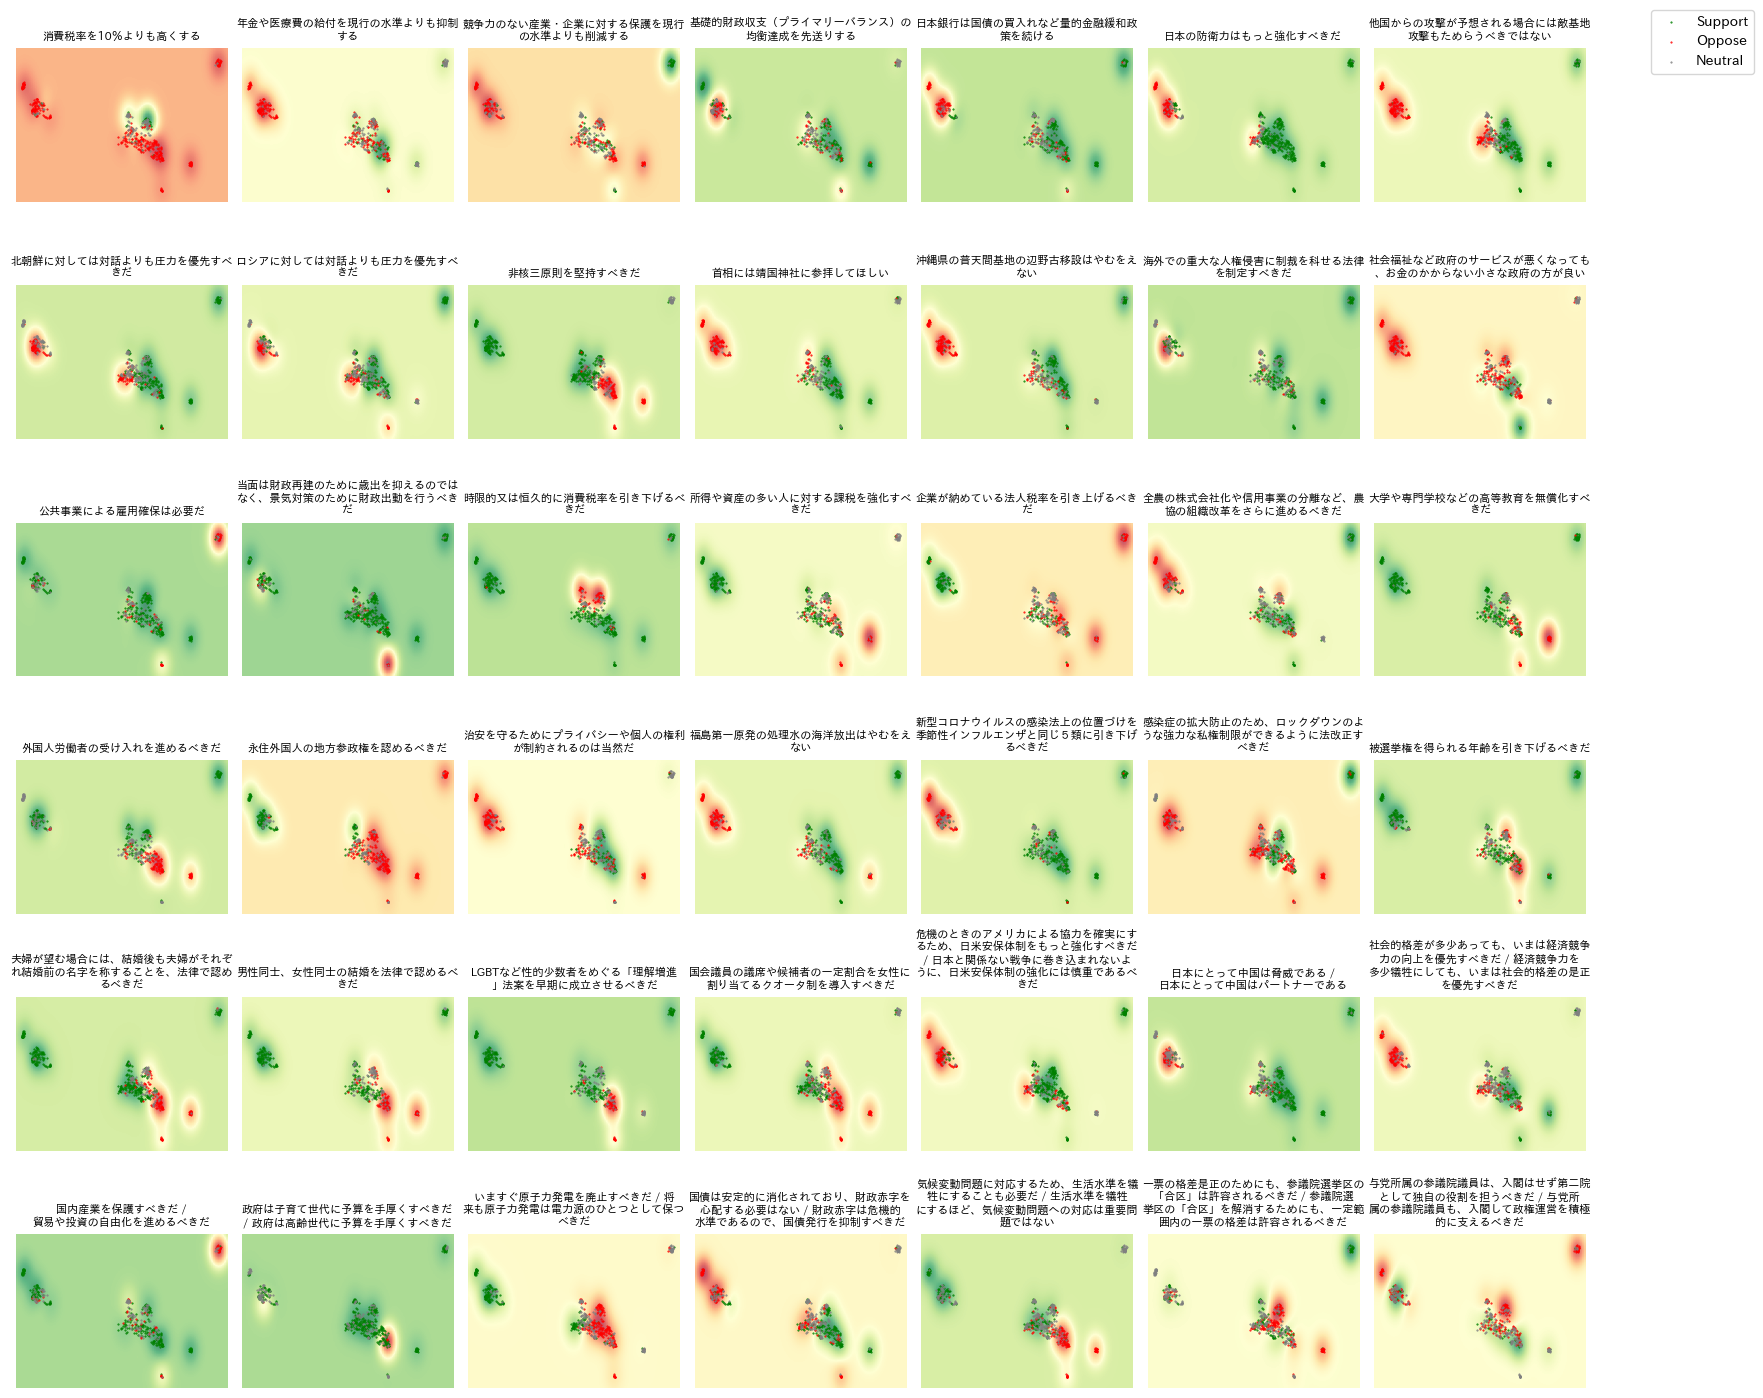

In [134]:
assert len(matrix.columns) == 42
# グリッドサイズの設定
n_rows, n_cols = 6, 7  # 6行×7列のグリッドで42個のプロットを配置

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 14))
axes = axes.flatten()  # 軸を1次元に展開してインデックスでアクセス

# 各質問ごとにプロット
for idx, qid in enumerate(matrix.columns):
    ax = axes[idx]
    contour(qid, ax=ax, show_legend=False)  # axパラメータで各サブプロットを指定
    ax.axis("off")  # 軸のラベルを非表示に

# 不要なサブプロットの非表示（質問数が42以外の場合のため）
for ax in axes[len(matrix.columns):]:
    ax.axis("off")

# 共通の凡例を設定（外枠に一度だけ表示）
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.show()